In [2]:
# 数据处理
import pandas as pd
import numpy as np

# 数据可视化
from pyecharts import options as opts
from pyecharts.charts import Pie,Bar,Line
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats

# 数据预处理
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from imblearn.over_sampling import ADASYN

# 特征工程
from statsmodels.stats.outliers_influence import variance_inflation_factor #多重共线性方差膨胀因子
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler


# 建模
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report  


# 模型优化
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import roc_curve, auc



# 数据读取与观察

In [3]:
# 读取数据
fat_data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
fat_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
fat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

- 共有2111条样本数据
- 所有特征无缺失值

## 特征描述

| 序号 | 字段名称                         | 描述                   |
|----|--------------------------------|----------------------|
| 0  | Gender                         | 性别                   |
| 1  | Age                            | 年龄（岁）                |
| 2  | Height                         | 身高（厘米）               |
| 3  | Weight                         | 体重（公斤）               |
| 4  | family_history_with_overweight | 家族中是否有超重史            |
| 5  | FAVC                           | 是否有食物作为主要选择的习惯（FAVC） |
| 6  | FCVC                           | 每日是否摄入蔬果（FCVC）       |
| 7  | NCP                            | 每日进餐次数（NCP）          |
| 8  | CAEC                           | 每周进食的碳水化合物频率（CAEC）   |
| 9  | SMOKE                          | 是否吸烟（SMOKE）          |
| 10 | CH2O                           | 每日饮用水量（CH2O）         |
| 11 | SCC                            | 是否有慢性疾病（SCC）         |
| 12 | FAF                            | 每周体力活动频率（FAF）        |
| 13 | TUE                            | 每日看电视/使用电子设备时间（TUE）  |
| 14 | CALC                           | 每周摄入钙频率（CALC）        |
| 15 | MTRANS                         | 出行方式（MTRANS）         |
| 16 | NObeyesdad                     | 肥胖类型分类（NObeyesdad）   |


In [5]:
# 描述变量
fat_data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
for item in fat_data.columns:
    print(f'{item}列有{fat_data[item].nunique()}个不同取值')
    print(f'{item}列统计信息：\n')
    print(fat_data[item].value_counts())
    print('*' * 60)                                           # 输出每列特征数据的不同取值个数以及每个数值的统计情况


Gender列有2个不同取值
Gender列统计信息：

Gender
Male      1068
Female    1043
Name: count, dtype: int64
************************************************************
Age列有1402个不同取值
Age列统计信息：

Age
18.000000    128
26.000000    101
21.000000     96
23.000000     89
19.000000     59
            ... 
23.320120      1
34.243146      1
18.549437      1
36.310292      1
23.664709      1
Name: count, Length: 1402, dtype: int64
************************************************************
Height列有1574个不同取值
Height列统计信息：

Height
1.700000    60
1.650000    50
1.600000    43
1.750000    39
1.620000    36
            ..
1.842943     1
1.706082     1
1.704141     1
1.705813     1
1.738836     1
Name: count, Length: 1574, dtype: int64
************************************************************
Weight列有1525个不同取值
Weight列统计信息：

Weight
80.000000     59
70.000000     43
50.000000     42
75.000000     40
60.000000     37
              ..
65.140408      1
87.279890      1
67.083121      1
90.138680      1
133.472641     

# 数据清洗

## 异常值处理

绘制箱线图查看异常值


In [7]:
float_data = fat_data.loc[:,['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']]
columns = float_data.columns.tolist()
columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

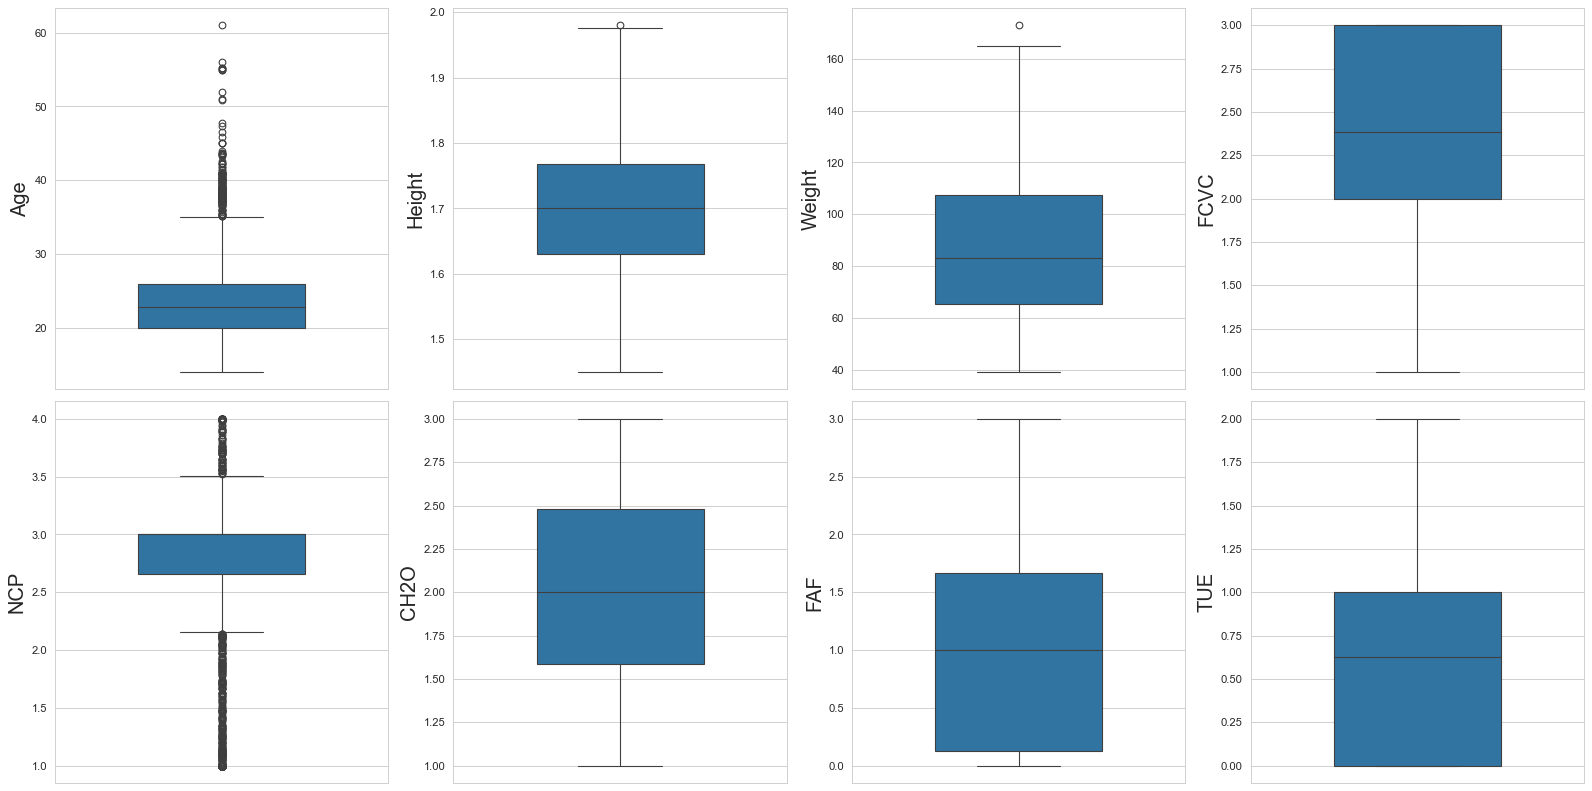

In [8]:
fig = plt.figure(figsize=(20, 10), dpi=80)  
# 绘制箱线图
for i in range(len(columns)):
    # 绘制子图
    plt.subplot(2, 4, i + 1)
    sns.boxplot(y=columns[i], data=float_data, orient='v', width=0.5)
    plt.ylabel(columns[i], fontsize=18)  

plt.tight_layout()  

plt.show() 

In [9]:
# 查看异常值
 # 计算四分位数
Q1 = float_data['NCP'].quantile(0.25)
Q3 = float_data['NCP'].quantile(0.75)
IQR = Q3 - Q1

# 确定异常值阈值
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 找出异常值
col_outliers = float_data[(float_data['NCP'] < lower_bound) | (float_data['NCP'] > upper_bound)]['NCP']
len(col_outliers)

579

In [10]:
col_outliers.value_counts()

NCP
1.000000    199
4.000000     69
1.894384      2
3.985442      2
3.691226      2
           ... 
1.411808      1
1.411685      1
1.068196      1
1.097312      1
1.089048      1
Name: count, Length: 307, dtype: int64

由于数据集条数为2111条，且NCP数据分布在一到四之间，NCP意为每日主餐数量，符合正常值分布，所以不进行异常值处理



查看离散数据

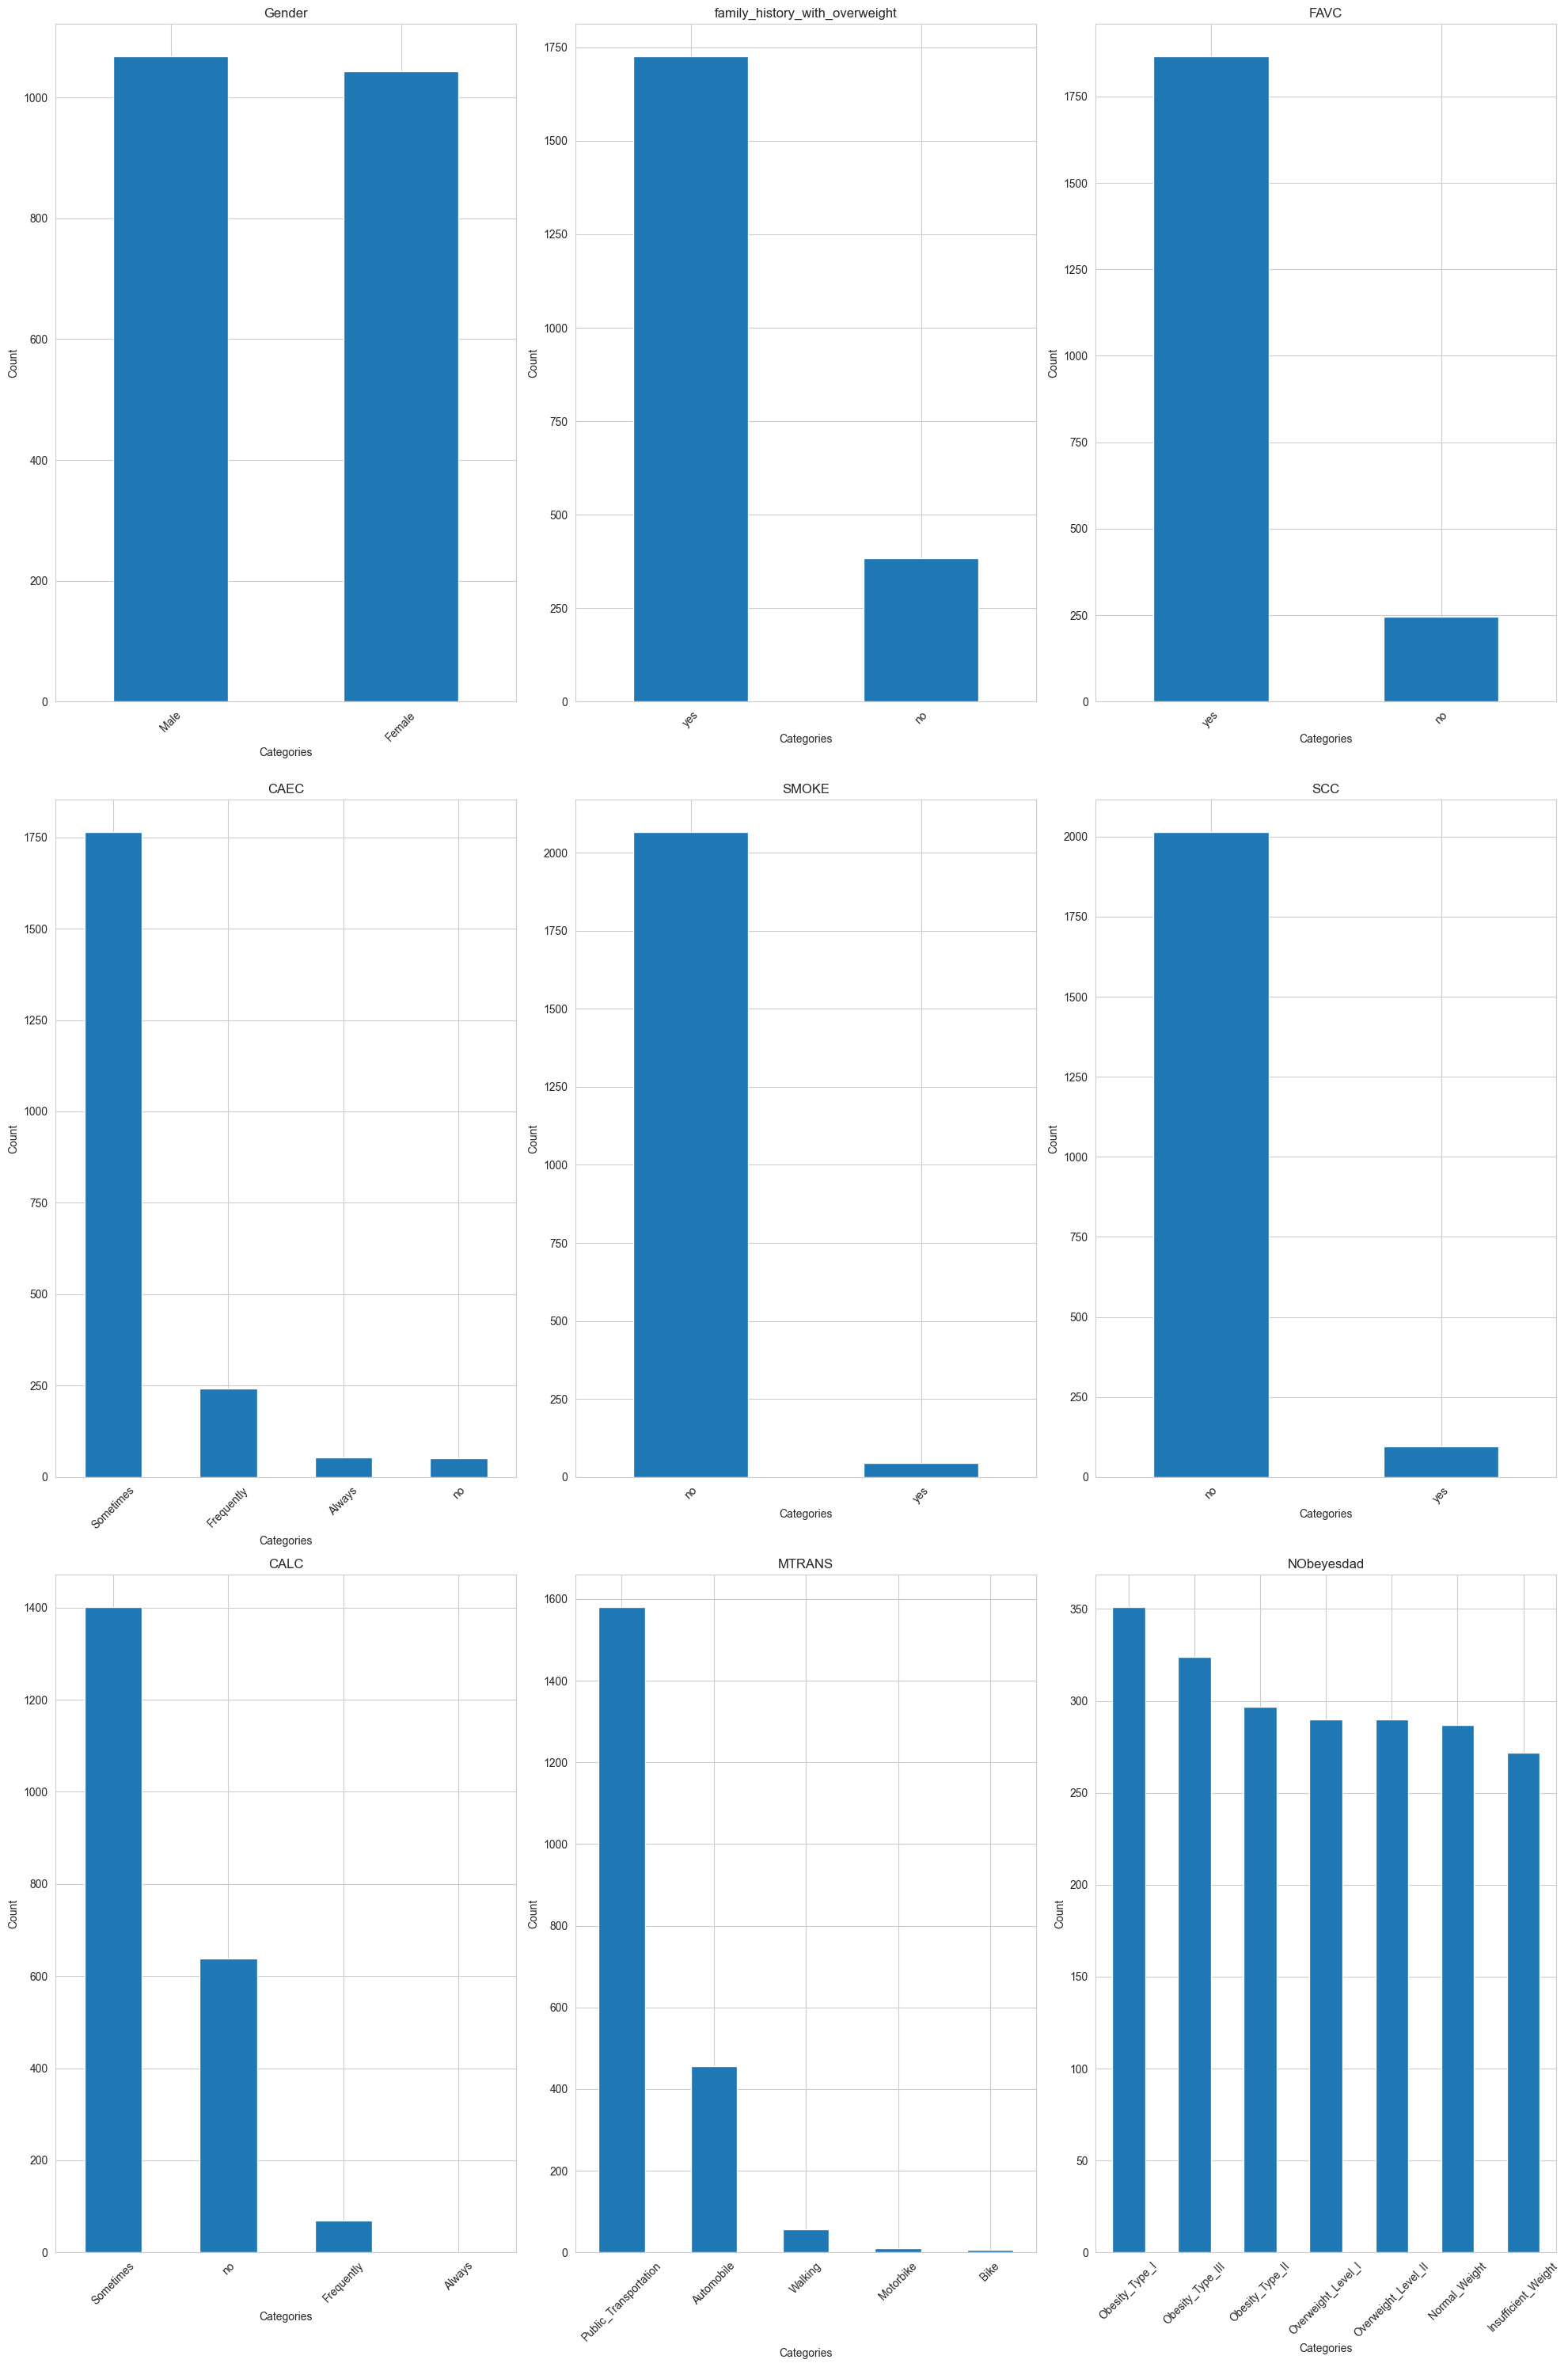

In [11]:
# 选择所有的object类型列
object_cols = fat_data.select_dtypes(include=['object']).columns

# 遍历每一列，绘制柱状图
plt.figure(figsize=(20, 30))

for i, col in enumerate(object_cols, 1):
    plt.subplot(3, 3, i)  # 创建子图，3行3列，当前位置i
    fat_data[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # 可选，旋转x轴标签以避免重叠

plt.tight_layout()  # 调整子图布局
plt.show()

## 标签重新分类

In [12]:
group1 = ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']
group2 = ['Normal_Weight', 'Insufficient_Weight']

tmp = ['Obesity' if db in group1 else 'No_Obesity' for db in fat_data['NObeyesdad']]
fat_data['NObeyesdad'] = tmp
fat_data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,No_Obesity
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,No_Obesity
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,No_Obesity
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Obesity
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity


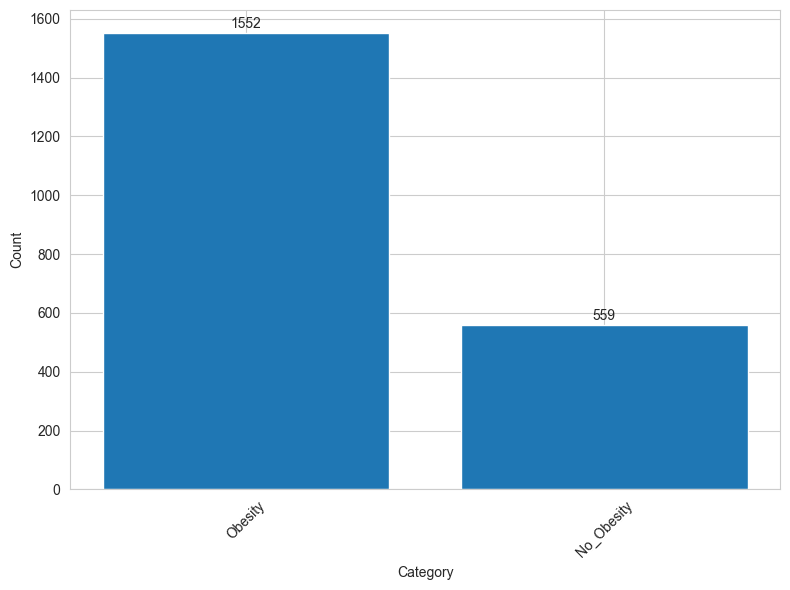

In [13]:
x_label = fat_data['NObeyesdad'].value_counts().index.to_list()
y_data = [fat_data['NObeyesdad'].value_counts()[i] for i in x_label]

# 创建柱状图
plt.figure(figsize=(8, 6))
plt.bar(x_label, y_data)


# 添加标题和标签
plt.xlabel('Category')
plt.ylabel('Count')

# 在柱状图上显示数值
for i, count in enumerate(y_data):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# 自定义 x 轴标签旋转
plt.xticks(rotation=45)

# 显示图形
plt.tight_layout()
plt.show()

有类别失衡的问题，后续需要对其进行平衡处理

## 缺失值处理


In [14]:
# 查看缺失值
fat_data.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

## 重复值处理

In [15]:
# 检查重复值
duplicate_rows = fat_data[fat_data.duplicated()]
# 查看重复值数量
fat_data.duplicated().sum()

24

In [16]:
duplicate_rows

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
98,Female,21.0,1.52,42.0,no,no,3.0,1.0,Frequently,no,1.0,no,0.0,0.0,Sometimes,Public_Transportation,No_Obesity
106,Female,25.0,1.57,55.0,no,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation,No_Obesity
174,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Obesity
179,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Obesity
184,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Obesity
209,Female,22.0,1.69,65.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,No_Obesity
309,Female,16.0,1.66,58.0,no,no,2.0,1.0,Sometimes,no,1.0,no,0.0,1.0,no,Walking,No_Obesity
460,Female,18.0,1.62,55.0,yes,yes,2.0,3.0,Frequently,no,1.0,no,1.0,1.0,no,Public_Transportation,No_Obesity
467,Male,22.0,1.74,75.0,yes,yes,3.0,3.0,Frequently,no,1.0,no,1.0,0.0,no,Automobile,No_Obesity
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation,No_Obesity


In [17]:
# 删除重复值
data_change = fat_data.drop_duplicates()
data_change.shape

(2087, 17)

## 数据类型转换

In [18]:
object_columns = data_change.select_dtypes(include=['object'])
for item in object_columns.columns:
    print(f'{item}列有{object_columns[item].nunique()}个不同取值')
    print(f'{item}列统计信息：\n')
    print(object_columns[item].value_counts())
    print('*' * 60)                                           # 输出每列特征数据的不同取值个数以及每个数值的统计情况


Gender列有2个不同取值
Gender列统计信息：

Gender
Male      1052
Female    1035
Name: count, dtype: int64
************************************************************
family_history_with_overweight列有2个不同取值
family_history_with_overweight列统计信息：

family_history_with_overweight
yes    1722
no      365
Name: count, dtype: int64
************************************************************
FAVC列有2个不同取值
FAVC列统计信息：

FAVC
yes    1844
no      243
Name: count, dtype: int64
************************************************************
CAEC列有4个不同取值
CAEC列统计信息：

CAEC
Sometimes     1761
Frequently     236
Always          53
no              37
Name: count, dtype: int64
************************************************************
SMOKE列有2个不同取值
SMOKE列统计信息：

SMOKE
no     2043
yes      44
Name: count, dtype: int64
************************************************************
SCC列有2个不同取值
SCC列统计信息：

SCC
no     1991
yes      96
Name: count, dtype: int64
************************************************************
CALC列有4个不同取值

Gender、family_history_with_overweight、FAVC、CAEC、CALC、MTRANS、NObeyesdad为object类型数据

In [19]:
# 处理有序离散型数据
# CAEC、CALC是有大小关系的
caec_dict = {'no':0, 'Sometimes':1, 'Frequently': 2, 'Always': 3 }
data_change['CAEC'] = data_change['CAEC'].map(caec_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1082694558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['CAEC'] = data_change['CAEC'].map(caec_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,1,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,No_Obesity
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,1,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,No_Obesity
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,1,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,No_Obesity
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,1,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Obesity
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,1,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,1,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,1,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,1,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,1,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity


In [20]:
calc_dict = {'no':0, 'Sometimes':1, 'Frequently': 2, 'Always': 3 }
data_change['CALC'] = data_change['CALC'].map(calc_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\3203863991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['CALC'] = data_change['CALC'].map(calc_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,1,no,2.000000,no,0.000000,1.000000,0,Public_Transportation,No_Obesity
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,1,yes,3.000000,yes,3.000000,0.000000,1,Public_Transportation,No_Obesity
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,1,no,2.000000,no,2.000000,1.000000,2,Public_Transportation,No_Obesity
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,1,no,2.000000,no,2.000000,0.000000,2,Walking,Obesity
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,1,no,2.000000,no,0.000000,0.000000,1,Public_Transportation,Obesity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,1,no,1.728139,no,1.676269,0.906247,1,Public_Transportation,Obesity
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,1,no,2.005130,no,1.341390,0.599270,1,Public_Transportation,Obesity
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,1,no,2.054193,no,1.414209,0.646288,1,Public_Transportation,Obesity
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,1,no,2.852339,no,1.139107,0.586035,1,Public_Transportation,Obesity


In [21]:
data_change['NObeyesdad'].value_counts()
no_beyesdad_dict = {"No_Obesity": 0, 'Obesity': 1}
data_change['NObeyesdad'] = data_change['NObeyesdad'].map(no_beyesdad_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\4161204146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['NObeyesdad'] = data_change['NObeyesdad'].map(no_beyesdad_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,1,no,2.000000,no,0.000000,1.000000,0,Public_Transportation,0
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,1,yes,3.000000,yes,3.000000,0.000000,1,Public_Transportation,0
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,1,no,2.000000,no,2.000000,1.000000,2,Public_Transportation,0
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,1,no,2.000000,no,2.000000,0.000000,2,Walking,1
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,1,no,2.000000,no,0.000000,0.000000,1,Public_Transportation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,1,no,1.728139,no,1.676269,0.906247,1,Public_Transportation,1
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,1,no,2.005130,no,1.341390,0.599270,1,Public_Transportation,1
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,1,no,2.054193,no,1.414209,0.646288,1,Public_Transportation,1
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,1,no,2.852339,no,1.139107,0.586035,1,Public_Transportation,1


In [22]:
family_history_with_overweight_dict = {'yes': 1, 'no': 0}
data_change['family_history_with_overweight'] = data_change['family_history_with_overweight'].map(family_history_with_overweight_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\206766367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['family_history_with_overweight'] = data_change['family_history_with_overweight'].map(family_history_with_overweight_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,1,no,2.0,3.0,1,no,2.000000,no,0.000000,1.000000,0,Public_Transportation,0
1,Female,21.000000,1.520000,56.000000,1,no,3.0,3.0,1,yes,3.000000,yes,3.000000,0.000000,1,Public_Transportation,0
2,Male,23.000000,1.800000,77.000000,1,no,2.0,3.0,1,no,2.000000,no,2.000000,1.000000,2,Public_Transportation,0
3,Male,27.000000,1.800000,87.000000,0,no,3.0,3.0,1,no,2.000000,no,2.000000,0.000000,2,Walking,1
4,Male,22.000000,1.780000,89.800000,0,no,2.0,1.0,1,no,2.000000,no,0.000000,0.000000,1,Public_Transportation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,yes,3.0,3.0,1,no,1.728139,no,1.676269,0.906247,1,Public_Transportation,1
2107,Female,21.982942,1.748584,133.742943,1,yes,3.0,3.0,1,no,2.005130,no,1.341390,0.599270,1,Public_Transportation,1
2108,Female,22.524036,1.752206,133.689352,1,yes,3.0,3.0,1,no,2.054193,no,1.414209,0.646288,1,Public_Transportation,1
2109,Female,24.361936,1.739450,133.346641,1,yes,3.0,3.0,1,no,2.852339,no,1.139107,0.586035,1,Public_Transportation,1


In [23]:
facv_dict = {'yes': 1, 'no': 0}
data_change['FAVC'] = data_change['FAVC'].map(facv_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\3125724146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['FAVC'] = data_change['FAVC'].map(facv_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,1,0,2.0,3.0,1,no,2.000000,no,0.000000,1.000000,0,Public_Transportation,0
1,Female,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,yes,3.000000,yes,3.000000,0.000000,1,Public_Transportation,0
2,Male,23.000000,1.800000,77.000000,1,0,2.0,3.0,1,no,2.000000,no,2.000000,1.000000,2,Public_Transportation,0
3,Male,27.000000,1.800000,87.000000,0,0,3.0,3.0,1,no,2.000000,no,2.000000,0.000000,2,Walking,1
4,Male,22.000000,1.780000,89.800000,0,0,2.0,1.0,1,no,2.000000,no,0.000000,0.000000,1,Public_Transportation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,1,3.0,3.0,1,no,1.728139,no,1.676269,0.906247,1,Public_Transportation,1
2107,Female,21.982942,1.748584,133.742943,1,1,3.0,3.0,1,no,2.005130,no,1.341390,0.599270,1,Public_Transportation,1
2108,Female,22.524036,1.752206,133.689352,1,1,3.0,3.0,1,no,2.054193,no,1.414209,0.646288,1,Public_Transportation,1
2109,Female,24.361936,1.739450,133.346641,1,1,3.0,3.0,1,no,2.852339,no,1.139107,0.586035,1,Public_Transportation,1


In [24]:
smoke_dict = {'yes': 1, 'no': 0}
data_change['SMOKE'] = data_change['SMOKE'].map(smoke_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1813317411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['SMOKE'] = data_change['SMOKE'].map(smoke_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,1,0,2.0,3.0,1,0,2.000000,no,0.000000,1.000000,0,Public_Transportation,0
1,Female,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,1,3.000000,yes,3.000000,0.000000,1,Public_Transportation,0
2,Male,23.000000,1.800000,77.000000,1,0,2.0,3.0,1,0,2.000000,no,2.000000,1.000000,2,Public_Transportation,0
3,Male,27.000000,1.800000,87.000000,0,0,3.0,3.0,1,0,2.000000,no,2.000000,0.000000,2,Walking,1
4,Male,22.000000,1.780000,89.800000,0,0,2.0,1.0,1,0,2.000000,no,0.000000,0.000000,1,Public_Transportation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,1,3.0,3.0,1,0,1.728139,no,1.676269,0.906247,1,Public_Transportation,1
2107,Female,21.982942,1.748584,133.742943,1,1,3.0,3.0,1,0,2.005130,no,1.341390,0.599270,1,Public_Transportation,1
2108,Female,22.524036,1.752206,133.689352,1,1,3.0,3.0,1,0,2.054193,no,1.414209,0.646288,1,Public_Transportation,1
2109,Female,24.361936,1.739450,133.346641,1,1,3.0,3.0,1,0,2.852339,no,1.139107,0.586035,1,Public_Transportation,1


In [25]:
scc_dict = {'yes': 1, 'no': 0}
data_change['SCC'] = data_change['SCC'].map(scc_dict)
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\2338844101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['SCC'] = data_change['SCC'].map(scc_dict)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,1,0,2.0,3.0,1,0,2.000000,0,0.000000,1.000000,0,Public_Transportation,0
1,Female,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,1,Public_Transportation,0
2,Male,23.000000,1.800000,77.000000,1,0,2.0,3.0,1,0,2.000000,0,2.000000,1.000000,2,Public_Transportation,0
3,Male,27.000000,1.800000,87.000000,0,0,3.0,3.0,1,0,2.000000,0,2.000000,0.000000,2,Walking,1
4,Male,22.000000,1.780000,89.800000,0,0,2.0,1.0,1,0,2.000000,0,0.000000,0.000000,1,Public_Transportation,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,1,3.0,3.0,1,0,1.728139,0,1.676269,0.906247,1,Public_Transportation,1
2107,Female,21.982942,1.748584,133.742943,1,1,3.0,3.0,1,0,2.005130,0,1.341390,0.599270,1,Public_Transportation,1
2108,Female,22.524036,1.752206,133.689352,1,1,3.0,3.0,1,0,2.054193,0,1.414209,0.646288,1,Public_Transportation,1
2109,Female,24.361936,1.739450,133.346641,1,1,3.0,3.0,1,0,2.852339,0,1.139107,0.586035,1,Public_Transportation,1


In [26]:
# Gender、MTRANS为无序数据
# 实例化标签编码类
label_encoder = LabelEncoder()

data_change['Gender'] = label_encoder.fit_transform(data_change['Gender'])
data_change['MTRANS'] = label_encoder.fit_transform(data_change['MTRANS'])
data_change

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\2223578965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['Gender'] = label_encoder.fit_transform(data_change['Gender'])
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\2223578965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_change['MTRANS'] = label_encoder.fit_transform(data_change['MTRANS'])


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,1,0,2.000000,0,0.000000,1.000000,0,3,0
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,1,3,0
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,1,0,2.000000,0,2.000000,1.000000,2,3,0
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,1,0,2.000000,0,2.000000,0.000000,2,4,1
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,1,0,2.000000,0,0.000000,0.000000,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,1,0,1.728139,0,1.676269,0.906247,1,3,1
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,1,0,2.005130,0,1.341390,0.599270,1,3,1
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,1,0,2.054193,0,1.414209,0.646288,1,3,1
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,1,0,2.852339,0,1.139107,0.586035,1,3,1


In [27]:
data_change.shape

(2087, 17)

# 探索性分析

## 描述性分析

In [115]:
# 绘制饼图
fat_x = fat_data['NObeyesdad'].unique()
fat_y = data_change['NObeyesdad'].value_counts().values.tolist()
data_pie = [*zip(fat_x, fat_y)]
c = (
    Pie()
    .add(series_name="left",data_pair=data_pie)
    .set_global_opts(title_opts=opts.TitleOpts(title="肥胖比例饼图", pos_bottom='5%'))
    .set_series_opts(label_opts=opts.LabelOpts(formatter = "{b}: {c} ({d}%)"))
    .render("肥胖比例饼图.html")
)

In [116]:
age_data = pd.crosstab(data_change['Age'], data_change['NObeyesdad'])
age_data.reset_index(inplace=True)
age_data['Age']

0       14.000000
1       15.000000
2       16.000000
3       16.093234
4       16.129279
          ...    
1397    55.022494
1398    55.137881
1399    55.246250
1400    56.000000
1401    61.000000
Name: Age, Length: 1402, dtype: float64

In [117]:
# 设置分箱宽度
bin_width = 7
# min 14， max 61
bins = np.arange(10.5, 66.6, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
age_data['Age'] = pd.cut(age_data['Age'], bins)

# 按照分箱后的满意度计算人数
hist_data = age_data.groupby('Age').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="年龄与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('年龄与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\年龄与是否肥胖的关系组合图.html'

In [118]:
height_data = pd.crosstab(data_change['Height'], data_change['NObeyesdad'])
height_data.reset_index(inplace=True)
height_data

NObeyesdad,Height,0,1
0,1.450000,0,1
1,1.456346,0,1
2,1.480000,0,1
3,1.481682,0,1
4,1.483284,0,1
...,...,...,...
1569,1.931263,0,1
1570,1.942725,0,1
1571,1.947406,0,1
1572,1.975663,0,1


In [119]:
# 设置分箱宽度
bin_width = 0.08
# min 1.45， max 1.98
bins = np.arange(1.45, 1.98, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
height_data['Height'] = pd.cut(height_data['Height'], bins)

# 按照分箱后的满意度计算人数
hist_data = height_data.groupby('Height').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="身高与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('身高与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\身高与是否肥胖的关系组合图.html'

In [120]:
weight_data = pd.crosstab(data_change['Weight'], data_change['NObeyesdad'])
weight_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 10
# min 39， max 173
bins = np.arange(35, 175, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
weight_data['Weight'] = pd.cut(weight_data['Weight'], bins)

# 按照分箱后的满意度计算人数
hist_data = weight_data.groupby('Weight').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="体重与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('体重与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\体重与是否肥胖的关系组合图.html'

In [121]:
family_history_with_overweight_data = pd.crosstab(data_change['family_history_with_overweight'], data_change['NObeyesdad'])
family_history_with_overweight_data.reset_index(inplace=True)

x_data = family_history_with_overweight_data['family_history_with_overweight'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=family_history_with_overweight_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=family_history_with_overweight_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="家族中是否有超重史与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = family_history_with_overweight_data[1]/(family_history_with_overweight_data[1] + family_history_with_overweight_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('家族中是否有超重史与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\家族中是否有超重史与是否肥胖的关系组合图.html'

In [122]:
favc_data = pd.crosstab(data_change['FAVC'], data_change['NObeyesdad'])
favc_data.reset_index(inplace=True)

x_data = favc_data['FAVC'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=favc_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=favc_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="是否有食物作为主要选择的习惯与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = favc_data[1]/(favc_data[1] + favc_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('是否有食物作为主要选择的习惯与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\是否有食物作为主要选择的习惯与是否肥胖的关系.html'

In [123]:
fcvc_data = pd.crosstab(data_change['FCVC'], data_change['NObeyesdad'])
fcvc_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 0.4
# min 1， max 3
bins = np.arange(1, 3.4, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
fcvc_data['FCVC'] = pd.cut(fcvc_data['FCVC'], bins)

# 按照分箱后的满意度计算人数
hist_data = fcvc_data.groupby('FCVC').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每日摄入蔬果量与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每日摄入蔬果量与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\每日摄入蔬果量与是否肥胖的关系组合图.html'

In [124]:
ncp_data = pd.crosstab(data_change['NCP'], data_change['NObeyesdad'])
ncp_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 0.4
# min 1， max 4
bins = np.arange(1, 4.5, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
ncp_data['NCP'] = pd.cut(ncp_data['NCP'], bins)

# 按照分箱后的满意度计算人数
hist_data = ncp_data.groupby('NCP').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每日进餐次数与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每日进餐次数与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\每日进餐次数与是否肥胖的关系组合图.html'

In [125]:
caec_data = pd.crosstab(data_change['CAEC'], data_change['NObeyesdad'])
caec_data.reset_index(inplace=True)

x_data = caec_data['CAEC'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=caec_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=caec_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每周进食的碳水化合物频率与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = caec_data[1]/(caec_data[1] + caec_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每周进食的碳水化合物频率与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\每周进食的碳水化合物频率与是否肥胖的关系.html'

In [126]:
smoke_data = pd.crosstab(data_change['SMOKE'], data_change['NObeyesdad'])
smoke_data.reset_index(inplace=True)

x_data = smoke_data['SMOKE'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=smoke_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=smoke_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="是否吸烟与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = smoke_data[1]/(smoke_data[1] + smoke_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('是否吸烟与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\是否吸烟与是否肥胖的关系.html'

In [127]:
calc_data = pd.crosstab(data_change['CALC'], data_change['NObeyesdad'])
calc_data.reset_index(inplace=True)

x_data = calc_data['CALC'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=calc_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=calc_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每周摄入钙频率与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = calc_data[1]/(calc_data[1] + calc_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每周摄入钙频率与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\每周摄入钙频率与是否肥胖的关系.html'

In [110]:
ch20_data = pd.crosstab(data_change['CH2O'], data_change['NObeyesdad'])
ch20_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 0.5
# min 1， max 3
bins = np.arange(0.75, 3.75, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
ch20_data['CH2O'] = pd.cut(ch20_data['CH2O'], bins)

# 按照分箱后的满意度计算人数
hist_data = ch20_data.groupby('CH2O').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每日饮用水量与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每日饮用水量与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\每日饮用水量与是否肥胖的关系组合图.html'

In [111]:
scc_data = pd.crosstab(data_change['SCC'], data_change['NObeyesdad'])
scc_data.reset_index(inplace=True)

x_data = scc_data['SCC'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=scc_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=scc_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="是否有慢性疾病与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = scc_data[1]/(scc_data[1] + scc_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('是否有慢性疾病与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\是否有慢性疾病与是否肥胖的关系.html'

In [112]:
faf_data = pd.crosstab(data_change['FAF'], data_change['NObeyesdad'])
faf_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 0.3
# min 0， max 3
bins = np.arange(0, 3.15, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
faf_data['FAF'] = pd.cut(faf_data['FAF'], bins)

# 按照分箱后的满意度计算人数
hist_data = faf_data.groupby('FAF').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每周体力活动频率与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每周体力活动频率与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\每周体力活动频率与是否肥胖的关系组合图.html'

In [40]:
tue_data = pd.crosstab(data_change['TUE'], data_change['NObeyesdad'])
tue_data.reset_index(inplace=True)

# 设置分箱宽度
bin_width = 0.2
# min 0， max 2
bins = np.arange(0, 2.15, bin_width)  

# 使用 pandas 的 cut 函数将数据分箱
tue_data['TUE'] = pd.cut(tue_data['TUE'], bins)

# 按照分箱后的满意度计算人数
hist_data = tue_data.groupby('TUE').agg({0: 'sum', 1: 'sum'}).reset_index()

# 提取直方图的横坐标（取每个箱子的中心点）
x_data = [round((bins[i] + bins[i+1]) / 2, 2) for i in range(len(bins) - 1)]


# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=hist_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=hist_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="每日看电视/使用电子设备时间与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = hist_data[1]/(hist_data[1] + hist_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('每日看电视或使用电子设备时间与是否肥胖的关系组合图.html')


'D:\\python\\school\\肥胖数据集\\每日看电视或使用电子设备时间与是否肥胖的关系组合图.html'

In [114]:
mtrans_data = pd.crosstab(data_change['MTRANS'], data_change['NObeyesdad'])
mtrans_data.reset_index(inplace=True)

x_data = mtrans_data['MTRANS'].tolist()
# 绘制柱状图
bar = (
    Bar()
    .add_xaxis(x_data)
    .add_yaxis(series_name='不肥胖', y_axis=mtrans_data[0].tolist(),yaxis_index=0, stack='stack1',z=0)
    .add_yaxis(series_name ='肥胖',y_axis=mtrans_data[1].tolist(), yaxis_index=0, stack='stack1', z=0)


    .extend_axis(
        yaxis=opts.AxisOpts(
            # 设置y轴属性
            type_="value",  
            # 给y轴设置名称
            name="肥胖率",  
            # 轴名称位于中间
            name_location="center",  
            # 轴名称与轴线距离30px
            name_gap=30,  
            )
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            name='人数',
            name_location="center",  # 设置名称位置
            name_gap=60,  # 设置轴名称与轴线之间的距离
        ),
        title_opts=opts.TitleOpts(title="出行方式与是否肥胖的关系"),
        # 图例设置
        legend_opts=opts.LegendOpts(pos_left='40%', pos_bottom='89%'),
        # 设置提示框和指示器
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross")
    )
    
)

# 计算每个项目数对应的离职率
fat_rate = mtrans_data[1]/(mtrans_data[1] + mtrans_data[0])
fat_rate = round(fat_rate, 2)
# 提取项目数和离职率
fat_rate = fat_rate.tolist()
# 创建折线图
line = (
    Line()
    .add_xaxis(list(range(0, len(fat_rate), 1)))
    .add_yaxis(series_name="肥胖率(%)", 
               y_axis=fat_rate, 
               yaxis_index=1,         
               label_opts=opts.LabelOpts(is_show=False, font_size=10, font_weight='bold')
               )
)
bar.overlap(line)
bar.render('出行方式与是否肥胖的关系.html')


'D:\\python\\school\\肥胖数据集\\出行方式与是否肥胖的关系.html'

## 数据归一化

In [29]:
scaler = StandardScaler()
# 选择数值类型进行归一化
columns_to_scale = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
all_data = data_change.copy()



In [30]:
scaler_data = scaler.fit_transform(data_change[columns_to_scale])
scaled_df = pd.DataFrame(scaler_data, columns=columns_to_scale)
# 还原数据
all_data[columns_to_scale] = scaled_df
all_data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,-0.526613,-0.887408,-0.872985,1,0,-0.788364,0.390906,1,0,-0.007810,0,-1.186977,0.554211,0,3,0
1,0,-0.526613,-1.960788,-1.178508,1,0,1.082164,0.390906,1,1,1.636552,1,2.328908,-1.090505,1,3,0
2,1,-0.212507,1.044677,-0.376509,1,0,-0.788364,0.390906,1,0,-0.007810,0,1.156947,0.554211,2,3,0
3,1,0.415705,1.044677,0.005395,0,0,1.082164,0.390906,1,0,-0.007810,0,1.156947,-1.090505,2,4,1
4,1,-0.369560,0.830001,0.112328,0,0,-0.788364,-2.225418,1,0,-0.007810,0,-1.186977,-1.090505,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,NaN,NaN,NaN,1,1,NaN,NaN,1,0,NaN,0,NaN,NaN,1,3,1
2107,0,NaN,NaN,NaN,1,1,NaN,NaN,1,0,NaN,0,NaN,NaN,1,3,1
2108,0,NaN,NaN,NaN,1,1,NaN,NaN,1,0,NaN,0,NaN,NaN,1,3,1
2109,0,NaN,NaN,NaN,1,1,NaN,NaN,1,0,NaN,0,NaN,NaN,1,3,1


In [31]:
all_data.isna().sum()

Gender                             0
Age                               24
Height                            24
Weight                            24
family_history_with_overweight     0
FAVC                               0
FCVC                              24
NCP                               24
CAEC                               0
SMOKE                              0
CH2O                              24
SCC                                0
FAF                               24
TUE                               24
CALC                               0
MTRANS                             0
NObeyesdad                         0
dtype: int64

查看缺失值发现出现缺失值，可能是数据在进行归一化时出现极端值导致归一化引发了数据的问题，对缺失数据进行均值填充处理

In [32]:
all_data = all_data.fillna(all_data.mean())
all_data.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

## 直方图与Q-Q图分析

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\2345628146.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=stats.norm, ax=ax)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\2345628146.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=stats.norm, ax=ax)
C:\Users\211

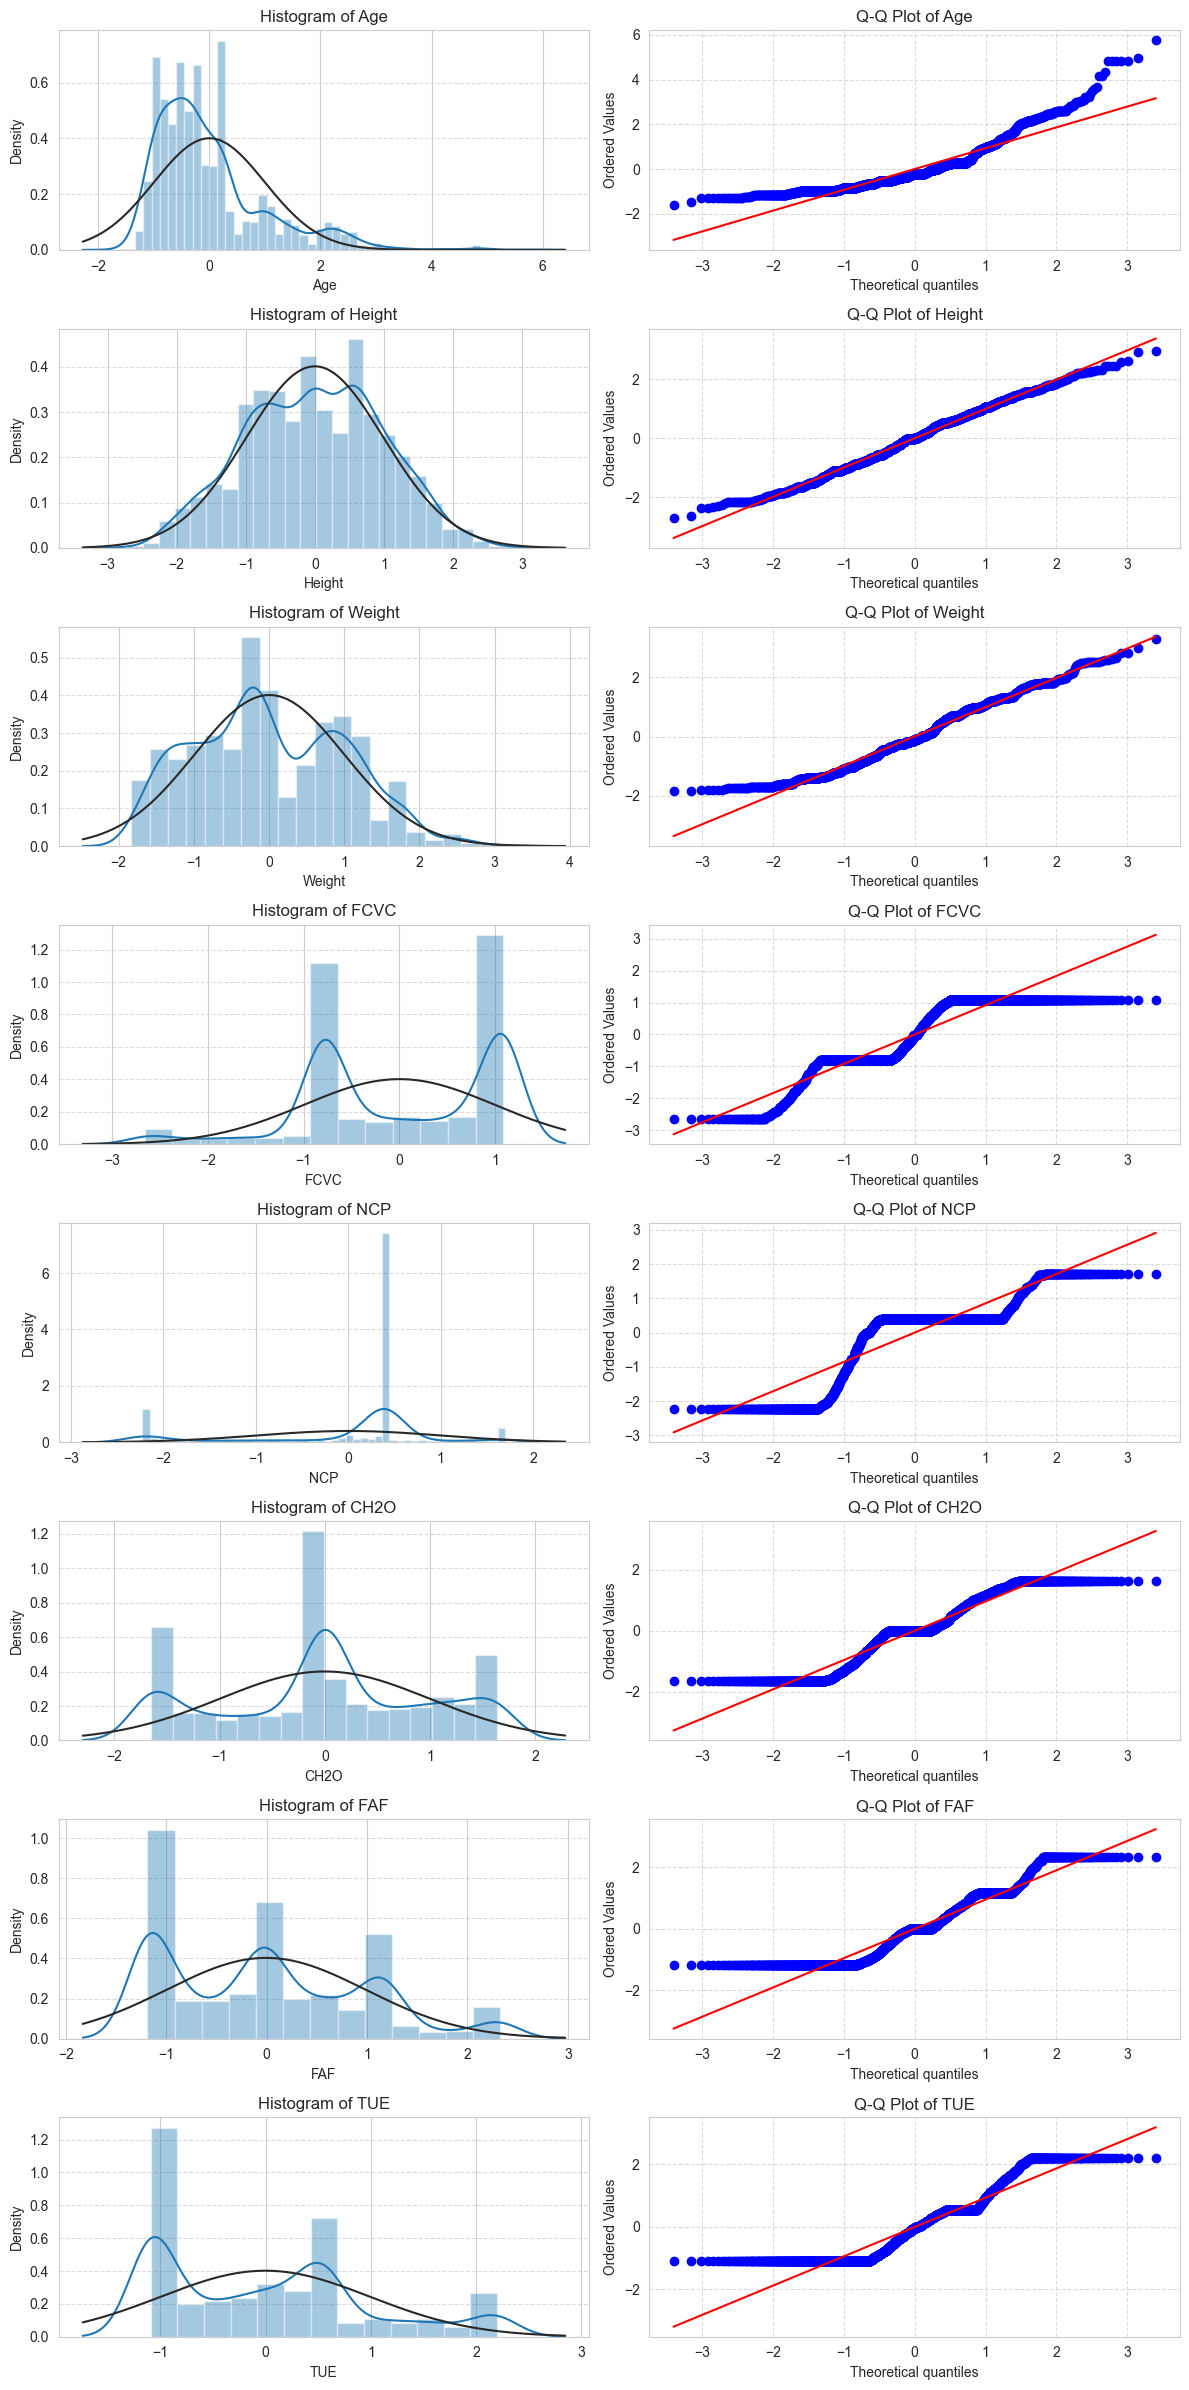

In [33]:
float_data = all_data.loc[:,['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']]

# 创建一个包含直方图和 Q-Q 图的子图布局
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 24))

# 遍历每个特征并绘制直方图和 Q-Q 图
for i, column in enumerate(float_data.columns):
    data = float_data[column]
    
    # 绘制直方图
    ax = axes[i, 0]
    sns.distplot(data, fit=stats.norm, ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 绘制 Q-Q 图
    ax = axes[i, 1]
    stats.probplot(data, plot=ax)
    ax.set_title(f'Q-Q Plot of {column}')
    ax.grid(True, linestyle='--', alpha=0.7)

# 调整子图之间的间距和整体布局
plt.tight_layout()
plt.show()

FCVC、NCP、CH20、FAF、TUE不满足正态分布

## KDE分布图

In [34]:
# 划分测试集、训练集
model_data = all_data.copy()
X = model_data.drop('NObeyesdad', axis=1)
y = model_data['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_train[col], color="Red", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_test[col], color="Blue", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_train[col], color="Red", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will 

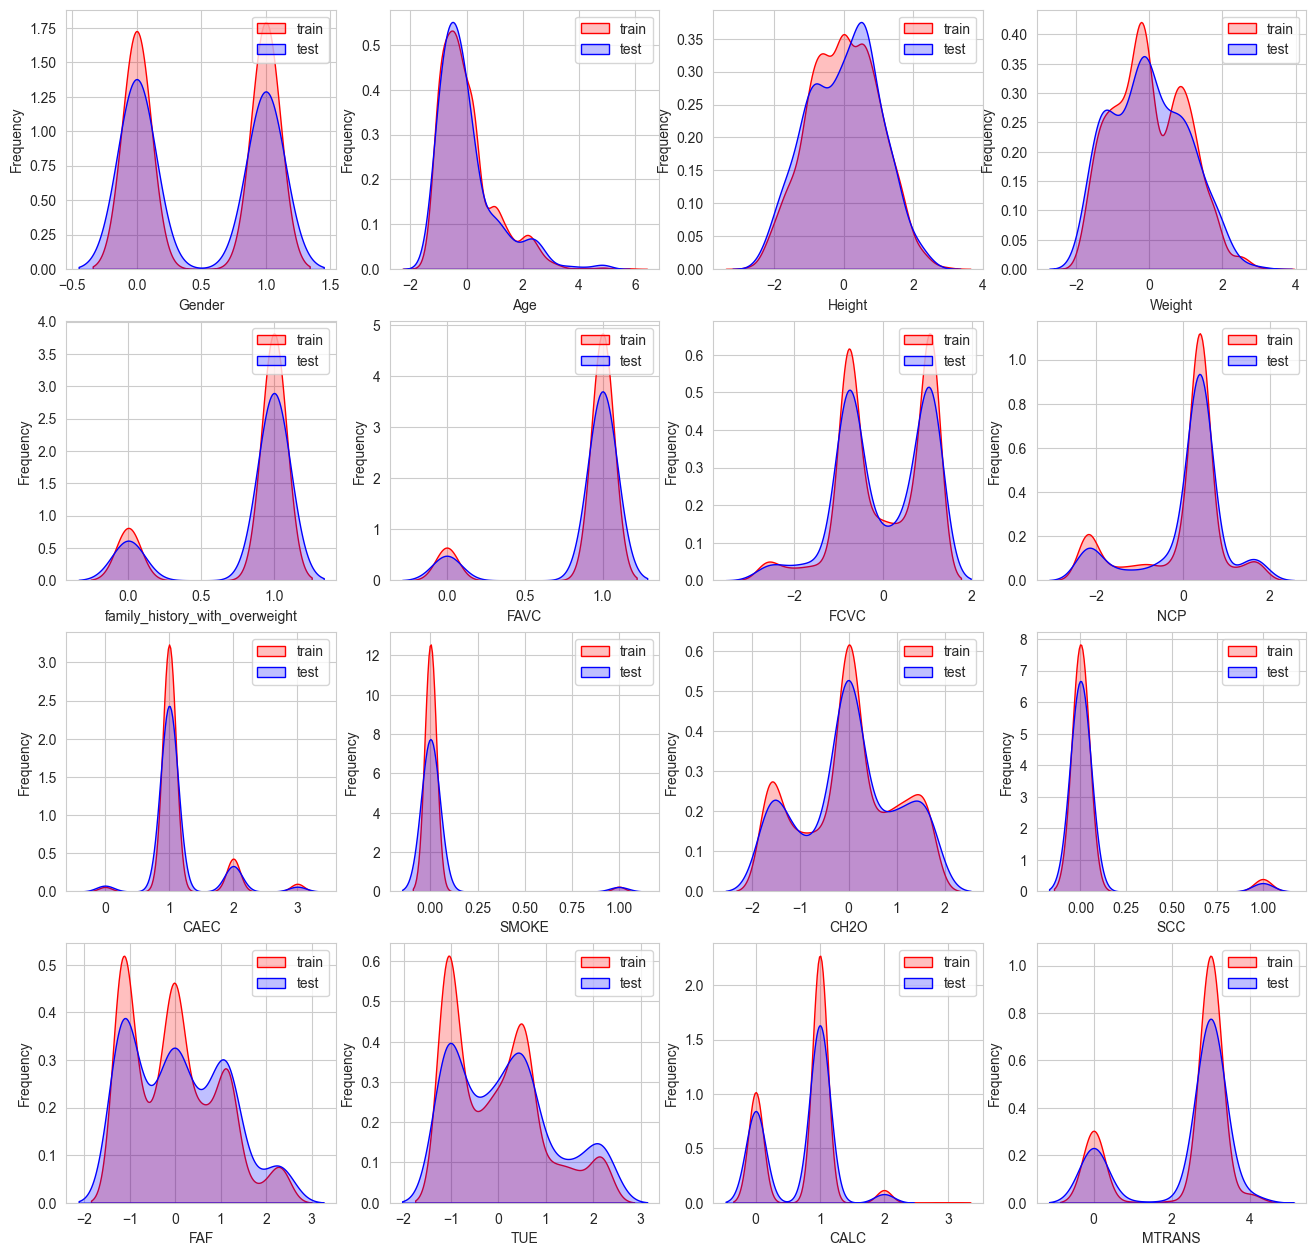

In [35]:
dist_cols = 4
dist_rows = len(X.columns)
plt.figure(figsize=(4 * dist_cols, 4 * dist_rows))
i = 1
for col in X.columns:
    ax = plt.subplot(dist_rows, dist_cols, i)
    ax = sns.kdeplot(x_train[col], color="Red", shade=True)
    ax = sns.kdeplot(x_test[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train", "test"])
    i += 1
plt.show()

特征在训练集和测试集上分布大致相同，无需进行数据删除

## 双变量分析

计算相关系数

In [36]:
data_corr = all_data.corr()
data_corr

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Gender,1.000000,0.116083,0.112696,0.017848,0.113492,0.061220,-0.179389,-0.050794,-0.074564,0.045501,-0.071310,-0.102435,-0.002861,-0.010964,-0.010574,-0.139044,0.073430
Age,0.116083,1.000000,-0.032662,0.197156,0.138007,0.029777,0.014369,-0.059373,-0.160387,0.029104,-0.042393,-0.040706,-0.149173,-0.306456,0.027583,-0.066294,0.281340
Height,0.112696,-0.032662,1.000000,0.456422,0.065443,0.078764,-0.042321,0.226653,-0.030876,0.009779,0.218827,-0.035726,0.289649,0.043354,0.020204,-0.118074,0.073965
Weight,0.017848,0.197156,0.456422,1.000000,0.403121,0.248993,0.218954,0.089688,-0.271094,-0.010132,0.202640,-0.152896,-0.058608,-0.078091,0.130076,-0.013792,0.582045
family_history_with_overweight,0.113492,0.138007,0.065443,0.403121,1.000000,0.214329,0.050424,-0.048541,-0.207738,0.014885,0.097431,-0.193947,-0.067968,-0.031739,-0.028403,-0.092730,0.504160
FAVC,0.061220,0.029777,0.078764,0.248993,0.214329,1.000000,0.040743,0.033592,-0.147921,-0.050713,0.028382,-0.191277,-0.054234,0.007426,0.087661,-0.069422,0.217409
FCVC,-0.179389,0.014369,-0.042321,0.218954,0.050424,0.040743,1.000000,0.034485,-0.000625,-0.006783,0.081778,0.007500,0.022289,-0.104130,0.088579,0.104192,0.033722
NCP,-0.050794,-0.059373,0.226653,0.089688,-0.048541,0.033592,0.034485,1.000000,0.046789,0.000355,0.074008,0.032457,0.132006,0.014404,0.035655,0.063934,-0.088152
CAEC,-0.074564,-0.160387,-0.030876,-0.271094,-0.207738,-0.147921,-0.000625,0.046789,1.000000,0.054960,-0.062663,0.109393,0.055852,0.026870,-0.039502,0.058158,-0.423496
SMOKE,0.045501,0.029104,0.009779,-0.010132,0.014885,-0.050713,-0.006783,0.000355,0.054960,1.000000,-0.016808,0.047384,0.033580,-0.012650,0.083181,-0.009995,-0.018374


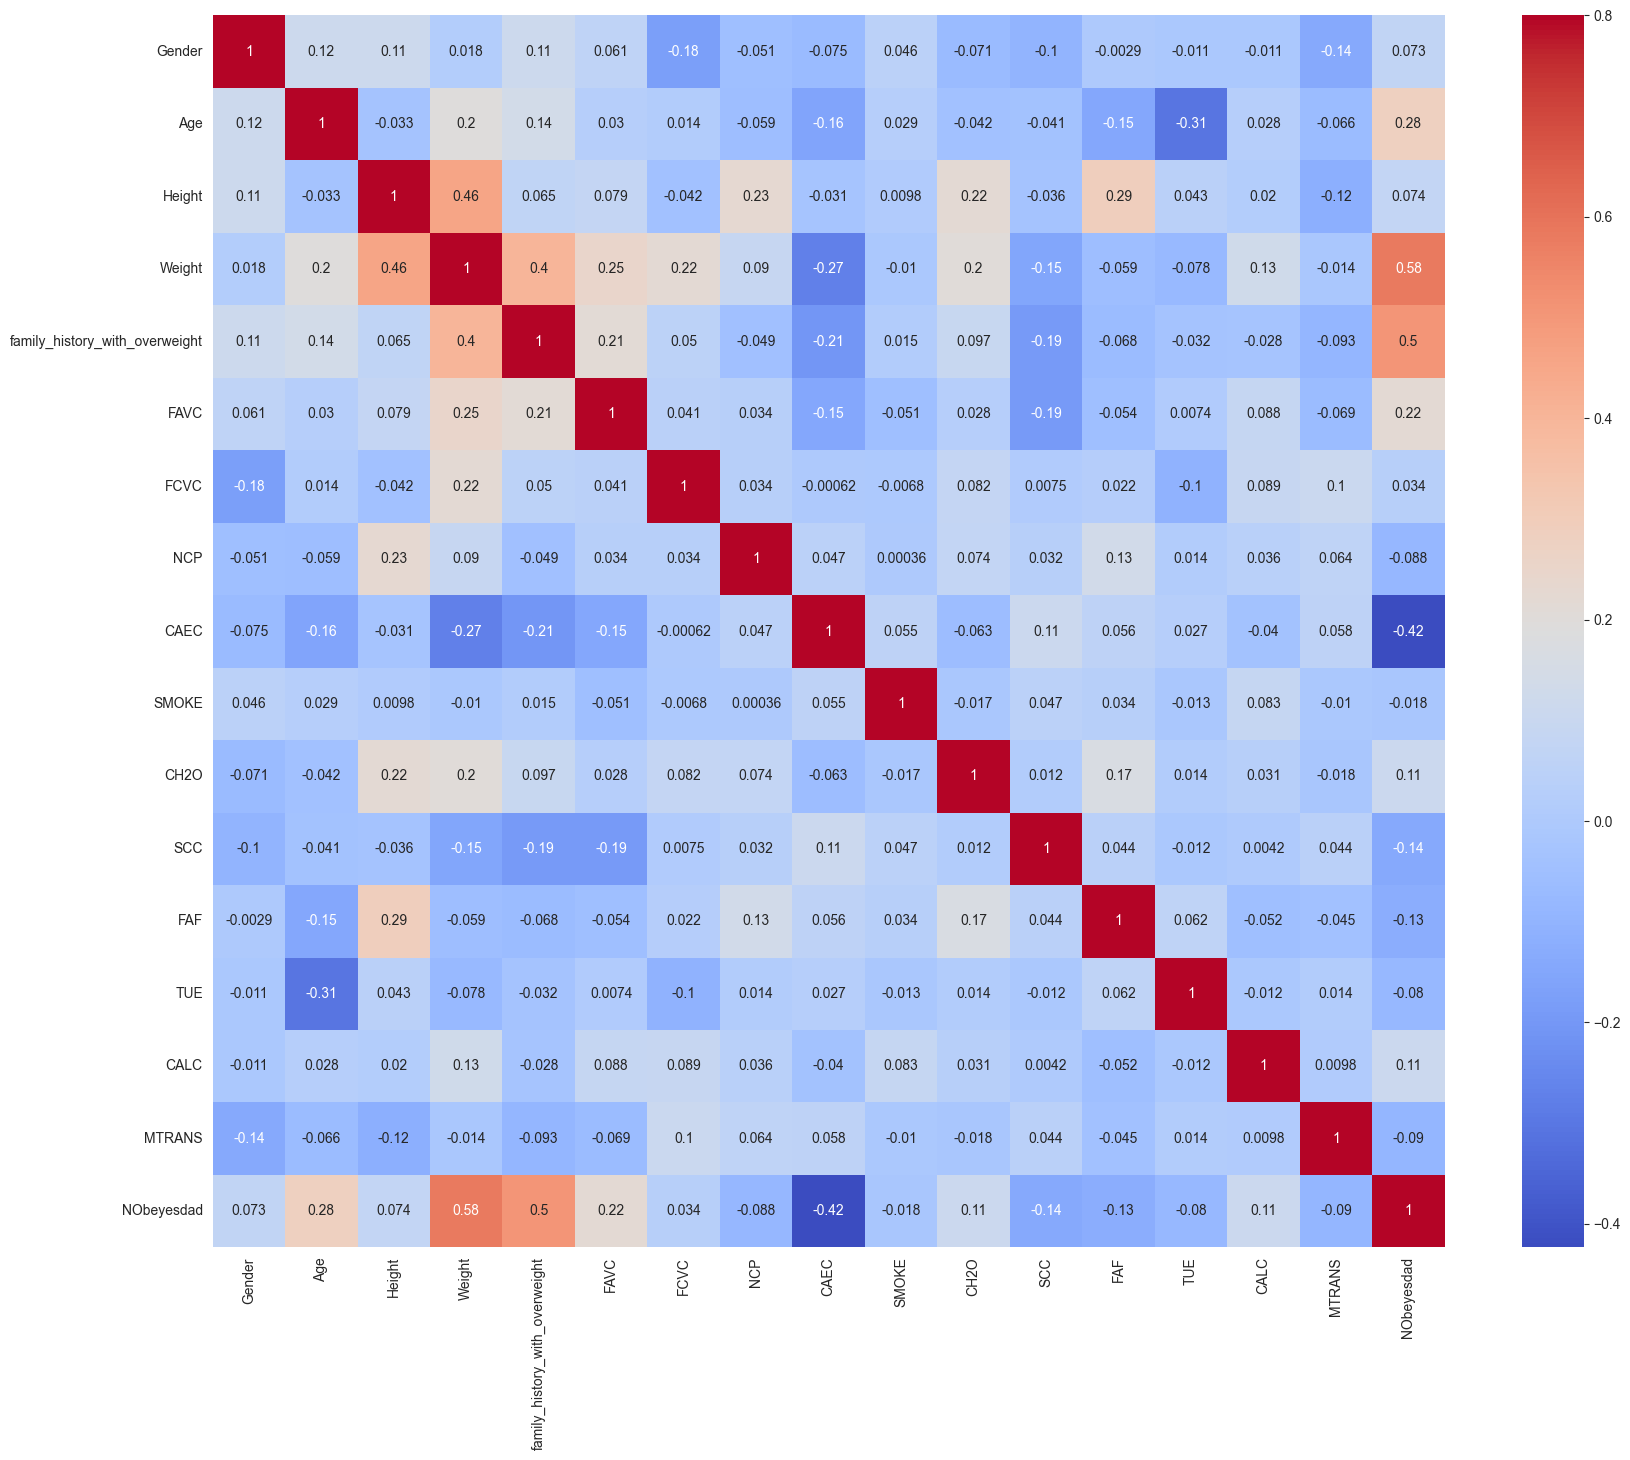

In [37]:
ax = plt.subplots(figsize=(20, 16))#调整画布大小
ax = sns.heatmap(data_corr, vmax=.8, square=True, cmap='coolwarm', annot=True)#画热力图   annot=True 显示系数

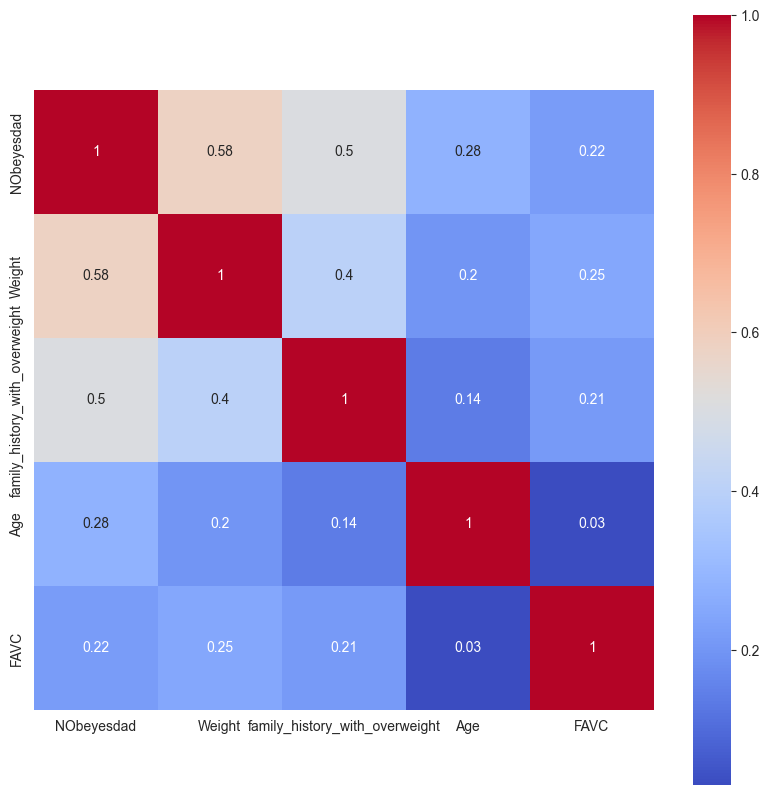

In [38]:
k = 5
cols = data_corr.nlargest(k, 'NObeyesdad')['NObeyesdad'].index
# 返回NObeyesdad这一列排序最大的5个，其对应NObeyesdad列的索引
hm = plt.subplots(figsize=(10, 10))  #调整画布大小
hm = sns.heatmap(all_data[cols].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

## 多重共线性分析

In [39]:
new_numerical=list(all_data.columns[:-1].values)
X=np.matrix(all_data[new_numerical])

VIF_dict = {}
for index, name in enumerate(new_numerical):
    VIF_dict[name]=variance_inflation_factor(X, index)

sorted_dict = dict(sorted(VIF_dict.items(), key=lambda item: item[1]))

print(sorted_dict)

{'SMOKE': 1.043344903301825, 'NCP': 1.0801095954046926, 'CH2O': 1.1061697240590616, 'SCC': 1.1118525026806843, 'TUE': 1.11953033803177, 'FCVC': 1.1497445366314127, 'FAF': 1.2000770773008054, 'Age': 1.209593813593131, 'Height': 1.6759528547988436, 'Weight': 1.9556220380976184, 'Gender': 2.1675254524155165, 'CALC': 2.9128174617933777, 'MTRANS': 3.976710038529213, 'CAEC': 5.900387104364177, 'family_history_with_overweight': 5.940622446392543, 'FAVC': 7.208669715612041}


不存在多重共线性


# 特征工程

## 特征删除

由于研究的目的是导致肥胖的主要因素，而身高和体重两个特征是评价是否肥胖的主要因素，而不是导致肥胖的原因，和研究目的不符合，所以将身高和体重两个特征删除 

In [40]:
all_data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,-0.526613,-0.887408,-0.872985,1,0,-0.788364,0.390906,1,0,-0.007810,0,-1.186977,0.554211,0,3,0
1,0,-0.526613,-1.960788,-1.178508,1,0,1.082164,0.390906,1,1,1.636552,1,2.328908,-1.090505,1,3,0
2,1,-0.212507,1.044677,-0.376509,1,0,-0.788364,0.390906,1,0,-0.007810,0,1.156947,0.554211,2,3,0
3,1,0.415705,1.044677,0.005395,0,0,1.082164,0.390906,1,0,-0.007810,0,1.156947,-1.090505,2,4,1
4,1,-0.369560,0.830001,0.112328,0,0,-0.788364,-2.225418,1,0,-0.007810,0,-1.186977,-1.090505,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.003694,0.000892,0.006228,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2107,0,0.003694,0.000892,0.006228,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2108,0,0.003694,0.000892,0.006228,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2109,0,0.003694,0.000892,0.006228,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1


In [41]:
drop_data = all_data.drop('Height',axis=1)
drop_data = drop_data.drop('Weight',axis=1)
drop_data

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,-0.526613,1,0,-0.788364,0.390906,1,0,-0.007810,0,-1.186977,0.554211,0,3,0
1,0,-0.526613,1,0,1.082164,0.390906,1,1,1.636552,1,2.328908,-1.090505,1,3,0
2,1,-0.212507,1,0,-0.788364,0.390906,1,0,-0.007810,0,1.156947,0.554211,2,3,0
3,1,0.415705,0,0,1.082164,0.390906,1,0,-0.007810,0,1.156947,-1.090505,2,4,1
4,1,-0.369560,0,0,-0.788364,-2.225418,1,0,-0.007810,0,-1.186977,-1.090505,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2107,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2108,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1
2109,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3,1


In [42]:
# 重新划分X，y
X = drop_data.drop('NObeyesdad', axis=1)
y = drop_data['NObeyesdad']

In [43]:
X

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,-0.526613,1,0,-0.788364,0.390906,1,0,-0.007810,0,-1.186977,0.554211,0,3
1,0,-0.526613,1,0,1.082164,0.390906,1,1,1.636552,1,2.328908,-1.090505,1,3
2,1,-0.212507,1,0,-0.788364,0.390906,1,0,-0.007810,0,1.156947,0.554211,2,3
3,1,0.415705,0,0,1.082164,0.390906,1,0,-0.007810,0,1.156947,-1.090505,2,4
4,1,-0.369560,0,0,-0.788364,-2.225418,1,0,-0.007810,0,-1.186977,-1.090505,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3
2107,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3
2108,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3
2109,0,0.003694,1,1,-0.001202,0.001748,1,0,-0.000617,0,-0.005086,-0.002423,1,3


## 平衡数据集


In [44]:
ros=RandomOverSampler(random_state=0) #采用随机过采样（上采样）
x_resample,y_resample=ros.fit_resample(X,y)
print(Counter(y))
print(Counter(y_resample))


Counter({1: 1538, 0: 549})
Counter({0: 1538, 1: 1538})


In [45]:
print(X.shape)
print(x_resample.shape)

(2087, 14)
(3076, 14)


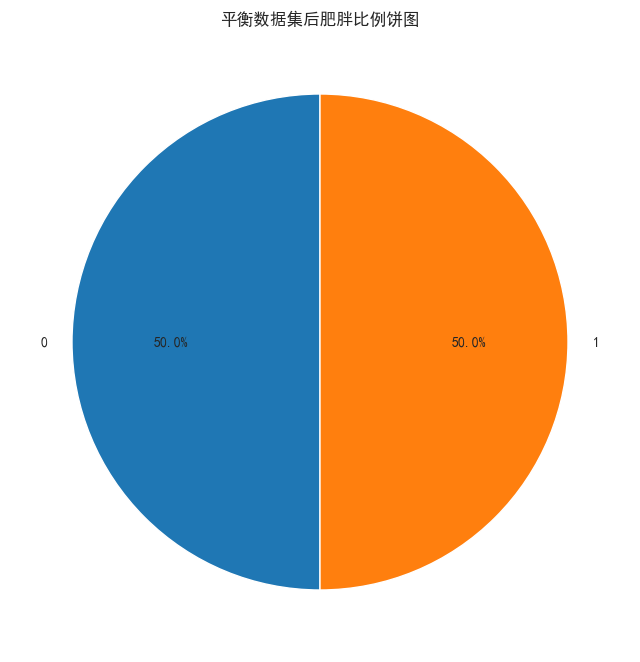

In [86]:
# 绘制饼图
plt.figure(figsize=(8,16))
plt.pie(y_resample.value_counts().to_list(),labels=y_resample.unique(), autopct="%1.1f%%", startangle=90)
plt.title("平衡数据集后肥胖比例饼图")
plt.show()

在平衡数据集后进行训练集测试集的重新划分：
- 避免数据泄露
- 充分利用原始数据集内信息
- 控制训练集测试集比例

In [47]:
# 重新划分数据集训练集
x_train, x_test, y_train, y_test =train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

#### 再次查看KDE分布图

C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_train[col], color="Red", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_test[col], color="Blue", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x_train[col], color="Red", shade=True)
C:\Users\21154\AppData\Local\Temp\ipykernel_7592\1983456079.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will 

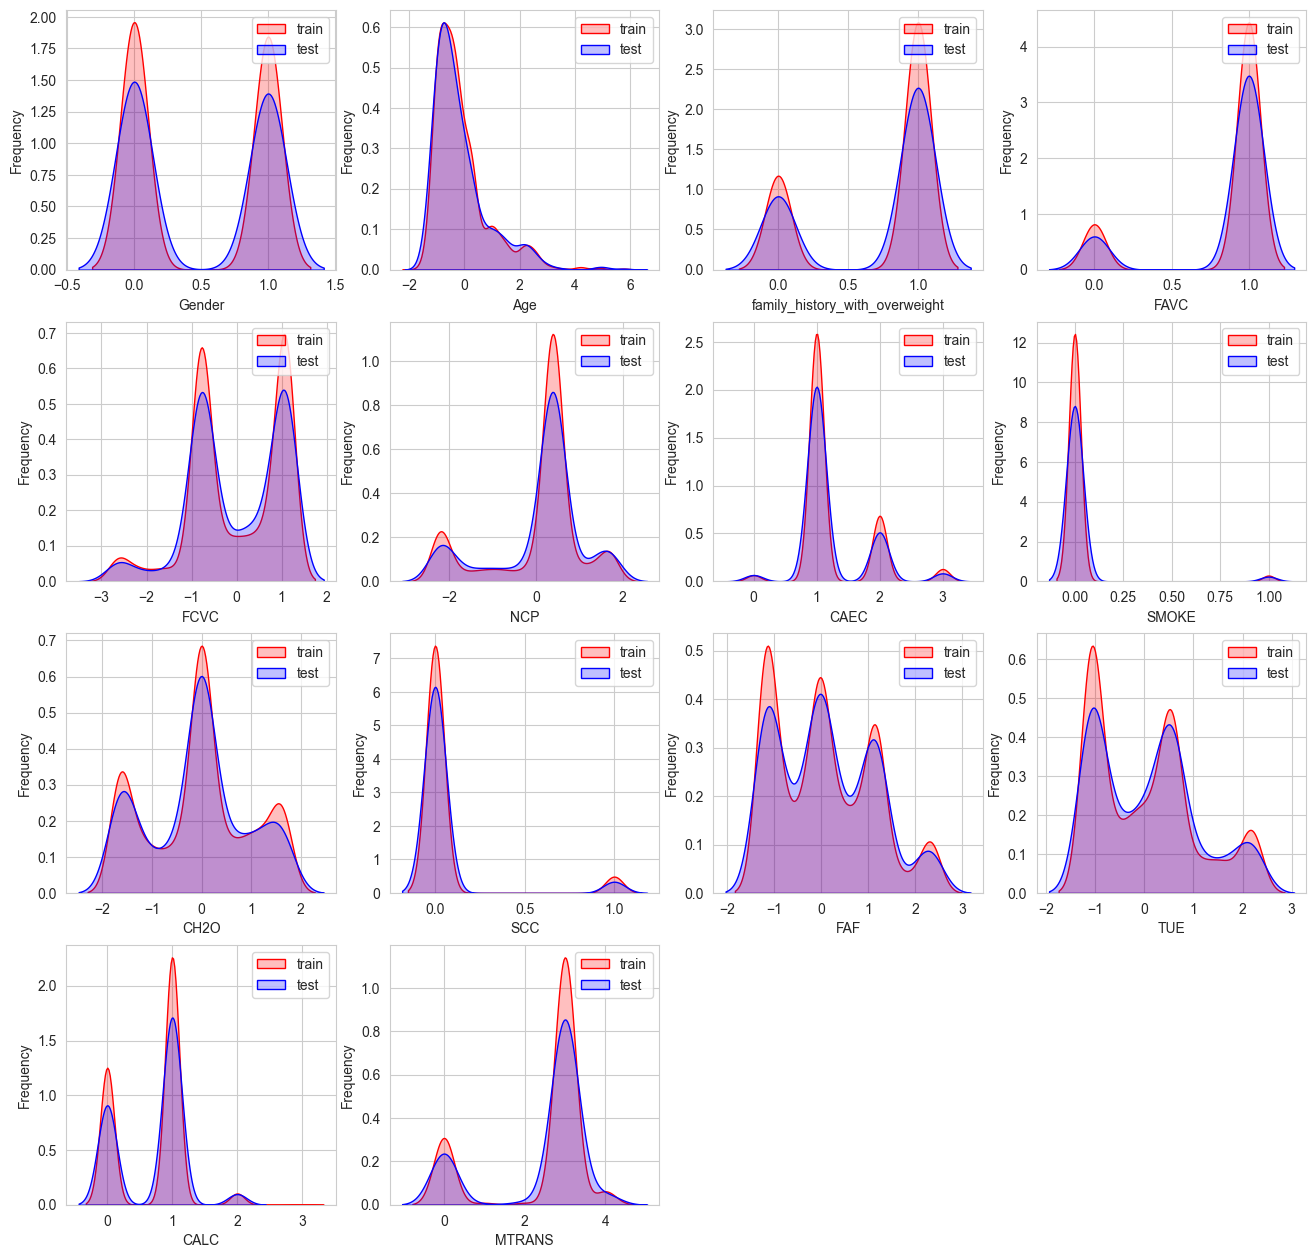

In [48]:
dist_cols = 4
dist_rows = len(X.columns)
plt.figure(figsize=(4 * dist_cols, 4 * dist_rows))
i = 1
for col in X.columns:
    ax = plt.subplot(dist_rows, dist_cols, i)
    ax = sns.kdeplot(x_train[col], color="Red", shade=True)
    ax = sns.kdeplot(x_test[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train", "test"])
    i += 1
plt.show()

## 嵌入法选择特征

### 建立模型

In [49]:
# 逻辑回归
logit = LogisticRegression()
# k近邻
knn = KNeighborsClassifier()
# 支持向量积
svc = SVC(kernel='linear', random_state=42)
# 随机森林
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# 决策树
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5, random_state=42)

### 特征选择

In [50]:
# 对模型进行特征选择
log_selector = SelectFromModel(logit,threshold=0.5)
log_selector.fit(x_train, y_train)
# 逻辑回归
x_selected_logit_train = log_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_logit_test = log_selector.transform(x_test)

In [51]:
# 对模型进行特征选择
svc_selector = SelectFromModel(svc,threshold=0.5)
svc_selector.fit(x_train, y_train)

# 支持向量积
x_selected_svc_train = svc_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_svc_test = svc_selector.transform(x_test)

In [52]:
# 对模型进行特征选择
rfc_selector = SelectFromModel(rfc, threshold=0.5)
rfc_selector.fit(x_train, y_train)

# 随机森林
x_selected_rfc_train = rfc_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_rfc_test = rfc_selector.transform(x_test)

D:\python\school\venv\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
D:\python\school\venv\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


In [53]:
# 对模型进行特征选择
decision_tree_selector = SelectFromModel(decision_tree,threshold=0.5)
decision_tree_selector.fit(x_train, y_train)

# 决策树
x_selected_decision_tree_train = decision_tree_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_decision_tree_test = decision_tree_selector.transform(x_test)

D:\python\school\venv\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
D:\python\school\venv\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


In [54]:
x_selected_logit_train.shape

(2460, 5)

In [55]:
x_selected_svc_train.shape

(2460, 2)

In [56]:
x_selected_rfc_train.shape

(2460, 0)

In [57]:
x_selected_decision_tree_train.shape

(2460, 0)

In [58]:
# 对模型进行特征选择
rfc_selector = SelectFromModel(rfc, threshold=0.08)
rfc_selector.fit(x_train, y_train)

# 随机森林
x_selected_rfc_train = rfc_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_rfc_test = rfc_selector.transform(x_test)

In [59]:
# 对模型进行特征选择
decision_tree_selector = SelectFromModel(decision_tree,threshold=0.08)
decision_tree_selector.fit(x_train, y_train)

# 决策树
x_selected_decision_tree_train = decision_tree_selector.transform(x_train)
# 对测试集的也进行筛选
x_selected_decision_tree_test = decision_tree_selector.transform(x_test)

In [60]:
x_selected_rfc_train.shape

(2460, 6)

In [61]:
x_selected_decision_tree_train.shape

(2460, 3)

# 模型建立与评估

模型在进行特征选择时已建立

### 模型评估

In [62]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


#### 逻辑回归

使用没进行特征选择的数据集

In [63]:
# 逻辑回归
logit = LogisticRegression()
# 模型训练
logit.fit(x_train,y_train)
y_pred_logit = logit.predict(x_test)

# 查看分类结果
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       316
           1       0.77      0.85      0.81       300

    accuracy                           0.81       616
   macro avg       0.81      0.81      0.81       616
weighted avg       0.81      0.81      0.80       616



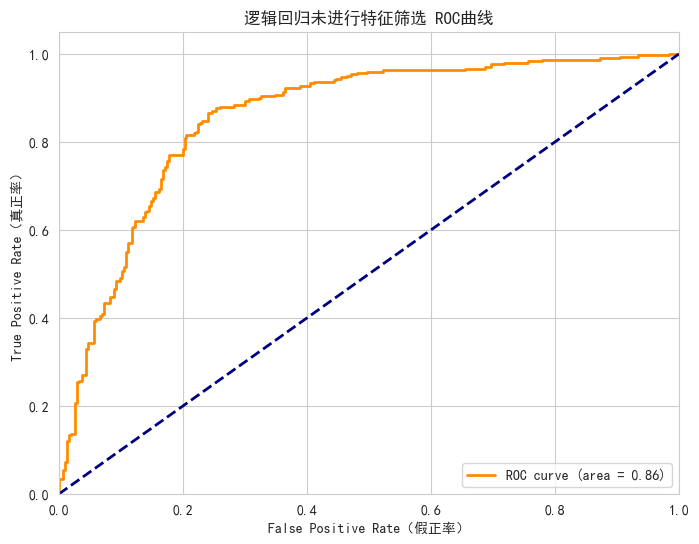

In [64]:
# 得到预测概率
y_score = logit.predict_proba(x_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('逻辑回归未进行特征筛选 ROC曲线')
plt.legend(loc='lower right')
plt.show()

ROC曲线较陡，AUC为0.86能看出预测效果较好

进行特征选择的数据

In [65]:
# 逻辑回归
logit = LogisticRegression()
# 模型训练
logit.fit(x_selected_logit_train,y_train)
y_pred_logit = logit.predict(x_selected_logit_test)

# 查看分类结果
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       316
           1       0.75      0.86      0.80       300

    accuracy                           0.79       616
   macro avg       0.80      0.79      0.79       616
weighted avg       0.80      0.79      0.79       616



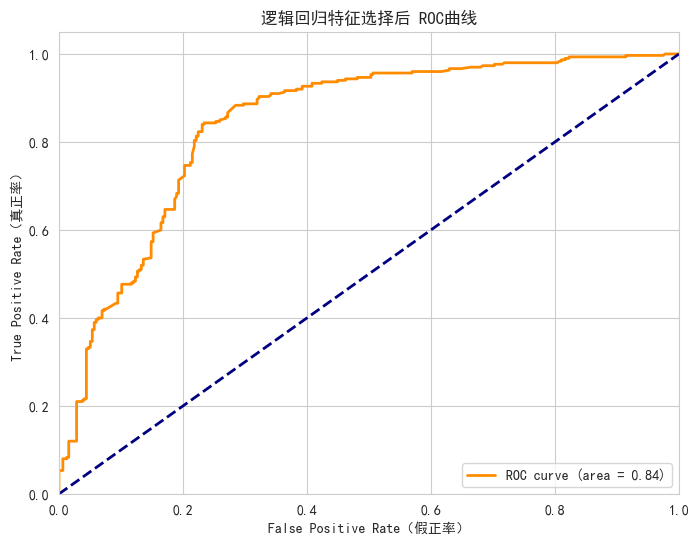

In [66]:
# 得到预测概率
y_score = logit.predict_proba(x_selected_logit_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('逻辑回归特征选择后 ROC曲线')
plt.legend(loc='lower right')
plt.show()

AUC面积为0.54，模型预测性能较差

#### K近邻

使用没进行特征选择的数据集

In [67]:
# k近邻
knn = KNeighborsClassifier()
# 模型训练
knn.fit(x_train,y_train)
# 预测
y_pred_knn = knn.predict(x_test)

# 查看分类结果
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       316
           1       0.80      0.88      0.84       300

    accuracy                           0.84       616
   macro avg       0.84      0.84      0.84       616
weighted avg       0.84      0.84      0.84       616



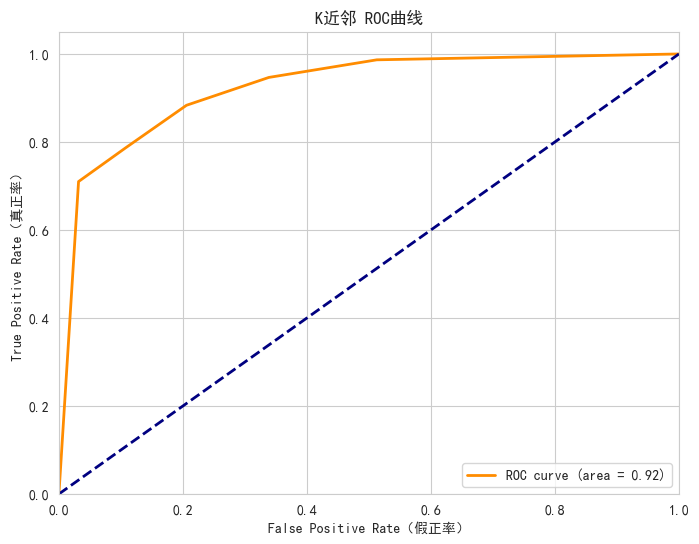

In [68]:
# 得到预测概率
y_score = knn.predict_proba(x_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('K近邻 ROC曲线')
plt.legend(loc='lower right')
plt.show()

ROC曲线较陡，AUC面积为0.92，模型预测性能较好

#### 支持向量积

使用未进行特征选择的数据集

In [69]:
# k近邻
svc = SVC(kernel='linear', random_state=42)
# 模型训练
svc.fit(x_train,y_train)
# 预测
y_pred_svc = svc.predict(x_test)

# 查看分类结果
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       316
           1       0.73      0.92      0.81       300

    accuracy                           0.80       616
   macro avg       0.81      0.80      0.80       616
weighted avg       0.82      0.80      0.79       616



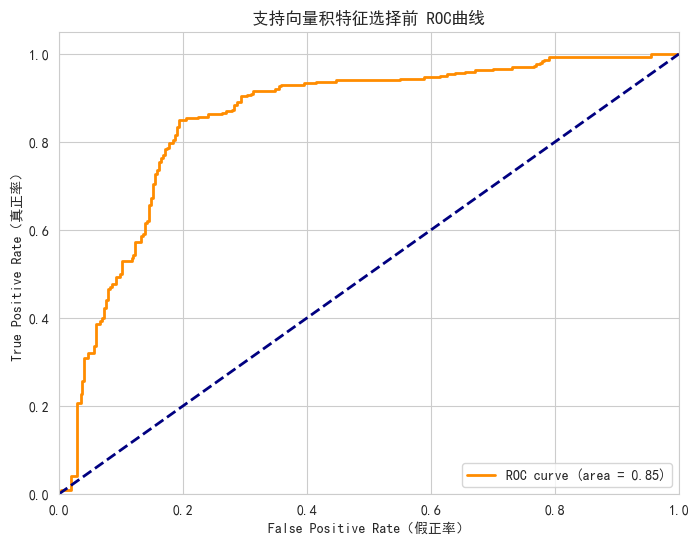

In [70]:
# 得到预测概率
y_score = svc.decision_function(x_test)
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('支持向量积特征选择前 ROC曲线')
plt.legend(loc='lower right')
plt.show()

使用进行特征选择的数据集

In [71]:
# k近邻
svc = SVC(kernel='linear', random_state=42)
# 模型训练
svc.fit(x_selected_svc_train,y_train)
# 预测
y_pred_svc = svc.predict(x_selected_svc_test)

# 查看分类结果
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       316
           1       0.73      0.92      0.81       300

    accuracy                           0.80       616
   macro avg       0.81      0.80      0.80       616
weighted avg       0.82      0.80      0.79       616



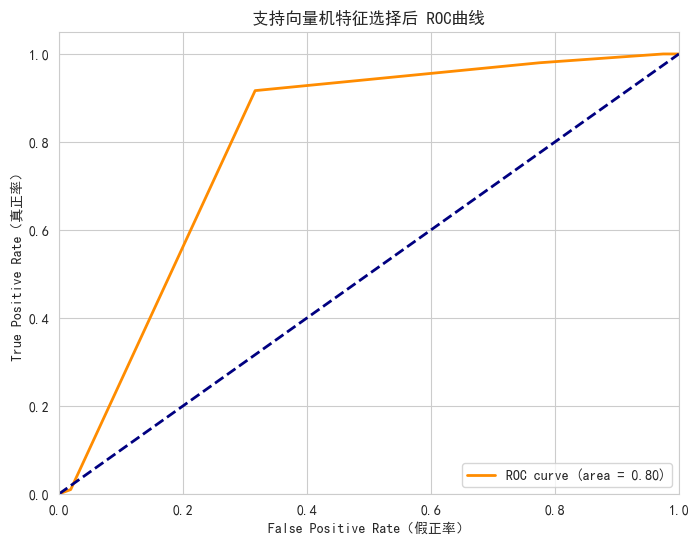

In [72]:
# 得到预测概率
y_score = svc.decision_function(x_selected_svc_test)
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('支持向量机特征选择后 ROC曲线')
plt.legend(loc='lower right')
plt.show()

- 特征选择前AUC曲线面积为0.85，平均准确率为0.8
- 特征选择后为AUC曲线面积为0.8， 平均准确率为0.8

#### 随机森林

使用未进行特征选择的数据集

In [73]:
# 随机森林
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# 模型训练
rfc.fit(x_train,y_train)
# 预测
y_pred_rfc = rfc.predict(x_test)

# 查看分类结果
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       316
           1       0.97      0.90      0.93       300

    accuracy                           0.94       616
   macro avg       0.94      0.94      0.94       616
weighted avg       0.94      0.94      0.94       616



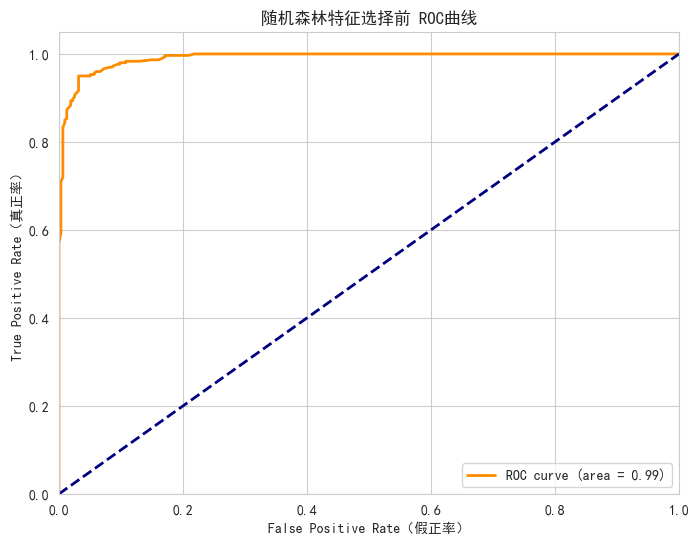

In [74]:
# 得到预测概率
y_score = rfc.predict_proba(x_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('随机森林特征选择前 ROC曲线')
plt.legend(loc='lower right')
plt.show()

使用进行特征选择的数据集

In [75]:
# 随机森林
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# 模型训练
rfc.fit(x_selected_rfc_train,y_train)
# 预测
y_pred_rfc = rfc.predict(x_selected_rfc_test)

# 查看分类结果
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       316
           1       0.97      0.89      0.93       300

    accuracy                           0.93       616
   macro avg       0.94      0.93      0.93       616
weighted avg       0.94      0.93      0.93       616



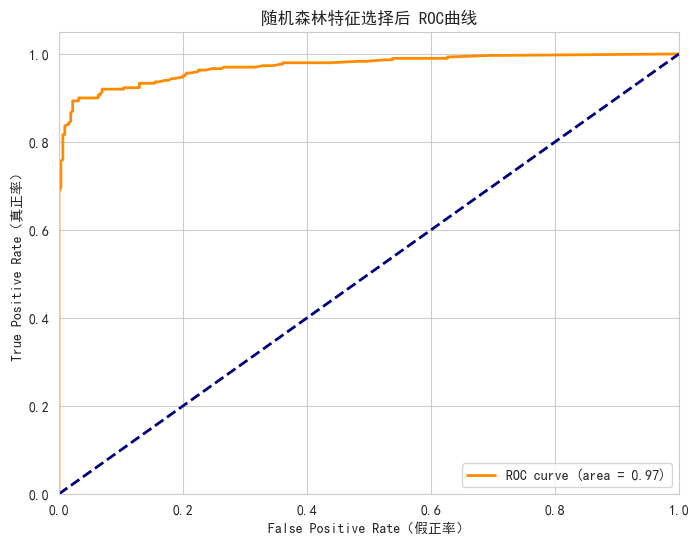

In [76]:
# 得到预测概率
y_score = rfc.predict_proba(x_selected_rfc_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('随机森林特征选择后 ROC曲线')
plt.legend(loc='lower right')
plt.show()

#### 决策树

使用未进行特征选择的数据集

In [77]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5, random_state=42)
# 模型训练
decision_tree.fit(x_train,y_train)
# 预测
y_pred_decision_tree = decision_tree.predict(x_test)

# 查看分类结果
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       316
           1       0.83      0.80      0.81       300

    accuracy                           0.82       616
   macro avg       0.82      0.82      0.82       616
weighted avg       0.82      0.82      0.82       616



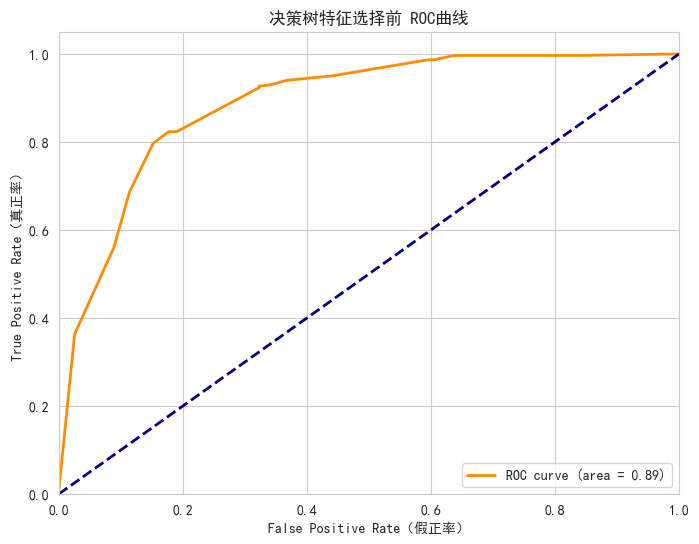

In [78]:
# 得到预测概率
y_score = decision_tree.predict_proba(x_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('决策树特征选择前 ROC曲线')
plt.legend(loc='lower right')
plt.show()

使用进行特征选择的数据集

In [79]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5, random_state=42)
# 模型训练
decision_tree.fit(x_selected_decision_tree_train,y_train)
# 预测
y_pred_decision_tree = decision_tree.predict(x_selected_decision_tree_test)

# 查看分类结果
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78       316
           1       0.73      0.92      0.81       300

    accuracy                           0.80       616
   macro avg       0.81      0.80      0.80       616
weighted avg       0.82      0.80      0.79       616



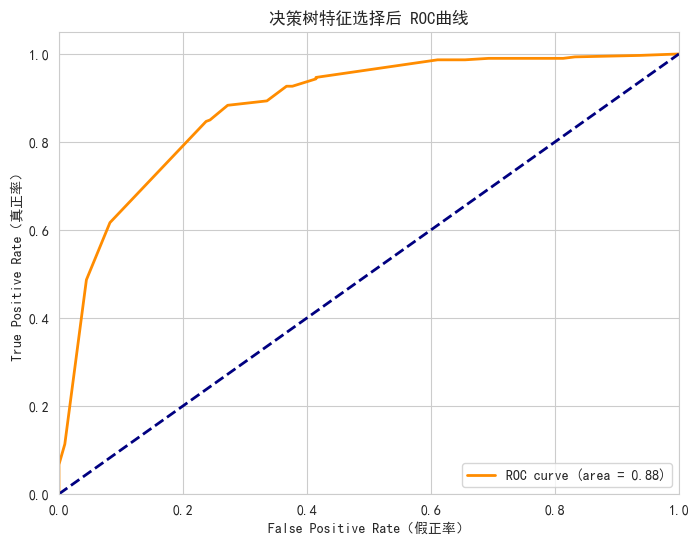

In [80]:
# 得到预测概率
y_score = decision_tree.predict_proba(x_selected_decision_tree_test)[:, 1]
# 计算ROC曲线的点
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# 计算AUC值
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate（假正率）')
plt.ylabel('True Positive Rate（真正率）')
plt.title('决策树特征选择后 ROC曲线')
plt.legend(loc='lower right')
plt.show()

- 综上数据，随机森林在不进行特征选择的数据集上表现较好，准确率为0.80，AUC曲线面积最大为0.99
- 进行特征选择的数据集训练的模型统一表现较差

#### 五折交叉验证

In [81]:
cv = KFold(n_splits=5,shuffle=True,random_state=42)  # 实例化交叉验证模式

def eval_model(model, x, y, cv, name):
    cross_result = cross_validate(model,
                                  x, y,
                                  cv=cv,
                                  return_train_score=True,
                                  verbose=True
                                  )
    
    trainScore = cross_result['train_score']
    testScore = cross_result['test_score']
    # 存储数据
    df = pd.DataFrame({'Model': name,
                       'trainScore': trainScore,
                       'testScore': testScore
    })
    return df


In [82]:
logit_result = eval_model(logit, x_resample, y_resample, cv, 'logit' )
knn_result = eval_model(knn, x_resample, y_resample, cv, 'knn' )
svc_result = eval_model(svc, x_resample, y_resample, cv, 'svc' )
rfc_result = eval_model(rfc, x_resample, y_resample, cv, 'rfc' )
decision_tree_result = eval_model(decision_tree, x_resample, y_resample, cv, 'decision_tree' )

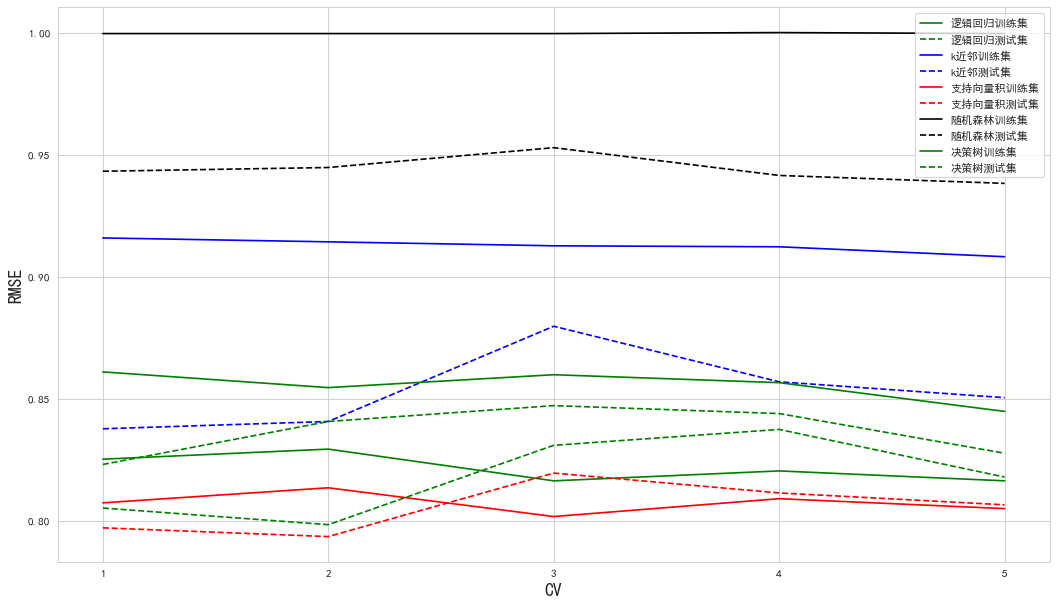

In [83]:
# 显示模型结果
plt.figure(figsize=(16,9),dpi=80)
xaxis = range(1,6)

#RMSE
plt.plot(xaxis,logit_result['trainScore'],color="green",label = "逻辑回归训练集")
plt.plot(xaxis,logit_result['testScore'],color="green",linestyle="--",label = "逻辑回归测试集")
plt.plot(xaxis,knn_result['trainScore'],color="blue",label = "k近邻训练集")
plt.plot(xaxis,knn_result['testScore'],color="blue",linestyle="--",label = "k近邻测试集")
plt.plot(xaxis,svc_result['trainScore'],color="red",label = "支持向量积训练集")
plt.plot(xaxis,svc_result['testScore'],color="red",linestyle="--",label = "支持向量积测试集")
plt.plot(xaxis,rfc_result['trainScore'],color="black",label = "随机森林训练集")
plt.plot(xaxis,rfc_result['testScore'],color="black",linestyle="--",label = "随机森林测试集")
plt.plot(xaxis,decision_tree_result['trainScore'],color="green",label = "决策树训练集")
plt.plot(xaxis,decision_tree_result['testScore'],color="green",linestyle="--",label = "决策树测试集")
plt.xticks([1,2,3,4,5])
plt.xlabel("CV",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.legend()
plt.show()


五折交叉验证结果同样显示，随机森林的表现较好

### 绘制学习曲线查看拟合问题

In [84]:
from sklearn.model_selection import learning_curve

# 定义绘制学习曲线函数
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


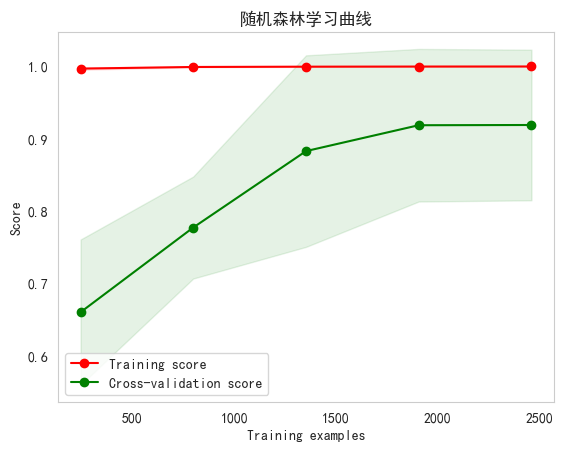

In [85]:
plot_learning_curve(rfc, "随机森林学习曲线", x_resample, y_resample, cv=5, n_jobs=-1)
plt.show()


## 随机森林参数调优

In [324]:
def hyperopt_objective(params):
    
    #定义评估器
    #需要搜索的参数需要从输入的字典中索引出来
    #不需要搜索的参数，可以是设置好的某个值
    #在需要整数的参数前调整参数类型
    reg = RandomForestClassifier(n_estimators = int(params["n_estimators"])
                                  ,max_depth = int(params["max_depth"])
                                  ,max_features = int(params["max_features"])
                                  ,min_impurity_decrease = params["min_impurity_decrease"]
                                  ,random_state=42
                                  ,verbose=False
                                  ,bootstrap=True
                                  , oob_score=True
                                  ,n_jobs=-1)
    
    #交叉验证结果
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,
                                     x_resample,
                                     y_resample
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                     ,error_score='raise'
                                    )
    
    return np.mean(abs(validation_loss["test_score"]))


In [331]:
# 定义参数空间
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",100,500,10)
                     , 'max_depth': hp.quniform("max_depth",10,20,1)
                     , "max_features": hp.quniform("max_features",10,20,1)
                     , "min_impurity_decrease":hp.quniform("min_impurity_decrease",0,3,1)
                    }


In [332]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(300)
    
    #定义代理模型
    #algo = partial(tpe.suggest, n_startup_jobs=20, n_EI_candidates=50)
    params_best = fmin(hyperopt_objective #目标函数
                       , space = param_grid_simple #参数空间
                       , algo = tpe.suggest 
                       #, algo = algo
                       , max_evals = max_evals #允许的迭代次数
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    max_depth = int(params_best['max_depth'])
    max_features = int(params_best['max_features'])
    min_impurity_decrease = int(params_best['min_impurity_decrease'])
    n_estimators = int(params_best['n_estimators'])
    
    return max_depth, max_features, min_impurity_decrease, n_estimators


In [333]:
max_depth1, max_features1, min_impurity_decrease1, n_estimators1 = param_hyperopt(50) 


100%|██████████| 50/50 [01:20<00:00,  1.62s/trial, best loss: 0.2363808716135139] 

 
 best params:  {'max_depth': 15.0, 'max_features': 15.0, 'min_impurity_decrease': 0.0, 'n_estimators': 210.0} 



In [344]:
max_depth2, max_features2, min_impurity_decrease2, n_estimators2 = param_hyperopt(100) 

100%|██████████| 100/100 [03:00<00:00,  1.80s/trial, best loss: 0.23218600835358702]

 
 best params:  {'max_depth': 13.0, 'max_features': 12.0, 'min_impurity_decrease': 0.0, 'n_estimators': 220.0} 



In [347]:
  # 模型调优
rfc_turn1 = RandomForestClassifier(n_estimators=n_estimators1, 
                                   random_state=42, 
                                   max_depth=max_depth1, 
                                   max_features=max_features1,
                                   min_impurity_decrease=min_impurity_decrease1,
                                   bootstrap=True, 
                                   oob_score=True)

result1 = eval_model(rfc_turn1, x_resample, y_resample, cv, 'random_forest_turn')


rfc_turn2 = RandomForestClassifier(n_estimators=n_estimators2, 
                                   random_state=42, 
                                   max_depth=max_depth2, 
                                   max_features=max_features2,
                                   min_impurity_decrease=min_impurity_decrease2,
                                   bootstrap=True, 
                                   oob_score=True)
result2 = eval_model(rfc_turn2, x_resample, y_resample, cv, 'random_forest_turn')



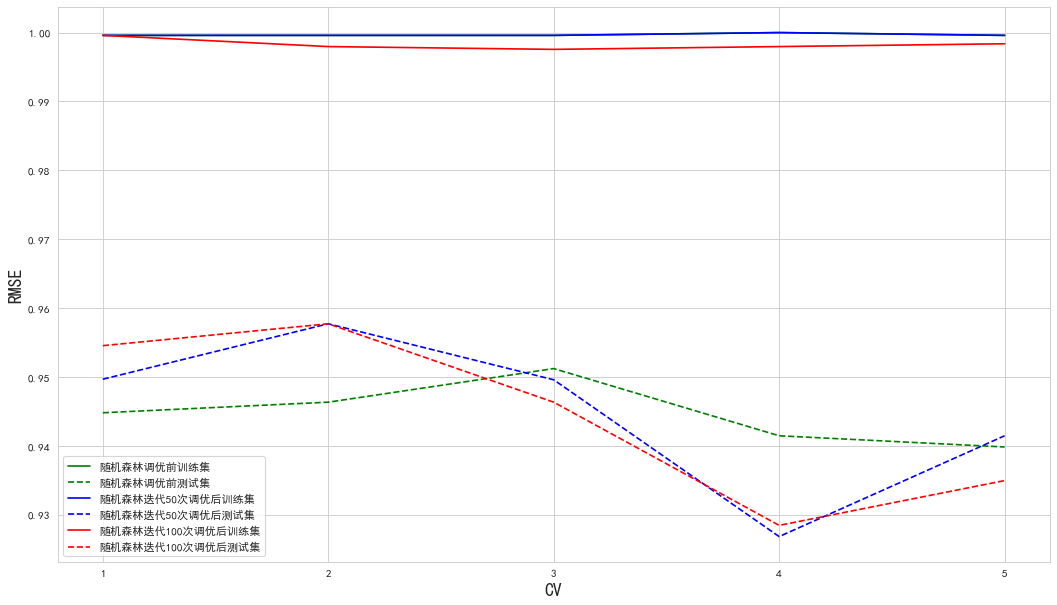

In [348]:
# 显示模型结果
plt.figure(figsize=(16,9),dpi=80)
xaxis = range(1,6)

#RMSE
plt.plot(xaxis,rfc_result['trainScore'],color="green",label = "随机森林调优前训练集")
plt.plot(xaxis,rfc_result['testScore'],color="green",linestyle="--",label = "随机森林调优前测试集")
plt.plot(xaxis,result1['trainScore'],color="blue",label = "随机森林迭代50次调优后训练集")
plt.plot(xaxis,result1['testScore'],color="blue",linestyle="--",label = "随机森林迭代50次调优后测试集")
plt.plot(xaxis,result2['trainScore'],color="red",label = "随机森林迭代100次调优后训练集")
plt.plot(xaxis,result2['testScore'],color="red",linestyle="--",label = "随机森林迭代100次调优后测试集")
plt.xticks([1,2,3,4,5])
plt.xlabel("CV",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.legend()
plt.show()


In [349]:
print(np.mean(rfc_result['testScore']))
print(np.mean(result1['testScore']))
print(np.mean(result2['testScore']))

0.9447333966846161
0.9450570161545772
0.9444050258684404


## 模型结果查看

In [357]:
# 使用默认参数训练的随机森林
# 随机森林
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# 模型训练
rfc.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [358]:
feature_importances = rfc.feature_importances_
feature_importances

array([0.02450169, 0.17093823, 0.14574659, 0.01999622, 0.0518303 ,
       0.08589328, 0.15072327, 0.00547947, 0.07721912, 0.01384128,
       0.08571558, 0.09551271, 0.03327192, 0.03933034])

In [359]:
x_resample.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')

In [360]:
sorted_indices = np.argsort(feature_importances)[::-1]
importance_df = pd.DataFrame({
    'Feature': x_resample.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                           Feature  Importance
1                              Age    0.170938
6                             CAEC    0.150723
2   family_history_with_overweight    0.145747
11                             TUE    0.095513
5                              NCP    0.085893
10                             FAF    0.085716
8                             CH2O    0.077219
4                             FCVC    0.051830
13                          MTRANS    0.039330
12                            CALC    0.033272
0                           Gender    0.024502
3                             FAVC    0.019996
9                              SCC    0.013841
7                            SMOKE    0.005479


- 随年龄增长新陈代谢下降，肌肉组织减少，使得体脂的积累更为容易，以此导致肥胖风险增加
- 每日碳水化物摄入的频率过高同样会导致高糖分、高脂肪的摄入，这些饮食习惯同样是肥胖的主要诱因之一。这些高量的碳水化合物不仅会提供过量能量，还可能导致血糖波动，增加人体脂肪存储
- 家庭遗传同样是导致肥胖的主要因素之一，遗传因素可能会导致人体新陈代谢速率、人体细胞对胰岛素的敏感性等生理特征，这些特征同样会导致肥胖的产生
- 同样久坐也会导致肥胖的产生，当每日看电子设备时间增加时同样会导致久坐时间的增加，降低人体能力消耗，导致人体的能量储备增加从而导致肥胖
- 饮食结构和进餐次数对于控制体重同样重要，频繁的小餐有助于维持血糖稳定和新陈代谢，从而减少过量进食的风险，降低肥胖的风险。
- 